In [3]:
import numpy as np
from pathlib import Path
import cv2
import math
import matplotlib.pyplot as plt
from numpy import genfromtxt
from pathlib import Path
import random

# Load images
# Define path to the data directory
data_dir = Path('/Users/carollong/Desktop/OptimalTransport/ShapeProject/Data')
all_dir = [f for f in data_dir.glob("*.*")]

# Reshape to size kxk
k = 128

all_img = []
# Process each img
for direc in all_dir:
    temp = 255-plt.imread(direc, 0)
    #convert to greyscale
    if len(temp.shape)>2:
        temp = temp[:,:,2]
    temp = cv2.resize(temp, (k,k))
    # Normalization, range from 0-1
    temp = temp / 255
    all_img.append(temp)
# Shuffle lists
random.shuffle(all_img)

In [4]:
# Convert to numpy array
all_img = np.array(all_img)
# Sanity Check: Checking the minimum and maximum values of all_img
print(all_img.min())
print(all_img.max())
print(all_img.shape)

0.0
1.0
(99, 128, 128)


In [5]:
# Reshaping input data
all_img = all_img.reshape(len(all_img),-1)
# Sanity check shape
print(all_img.shape)

(99, 16384)


In [20]:
from sklearn.cluster import KMeans
total_clusters = 9
# Initialize the K-Means model
kmeans = KMeans(n_clusters = total_clusters, random_state=0)
# Fitting the model to training set
kmeans.fit(all_img)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [21]:
centroids = kmeans.cluster_centers_

In [22]:
print(centroids.shape)

(9, 16384)


### traditional K-means result

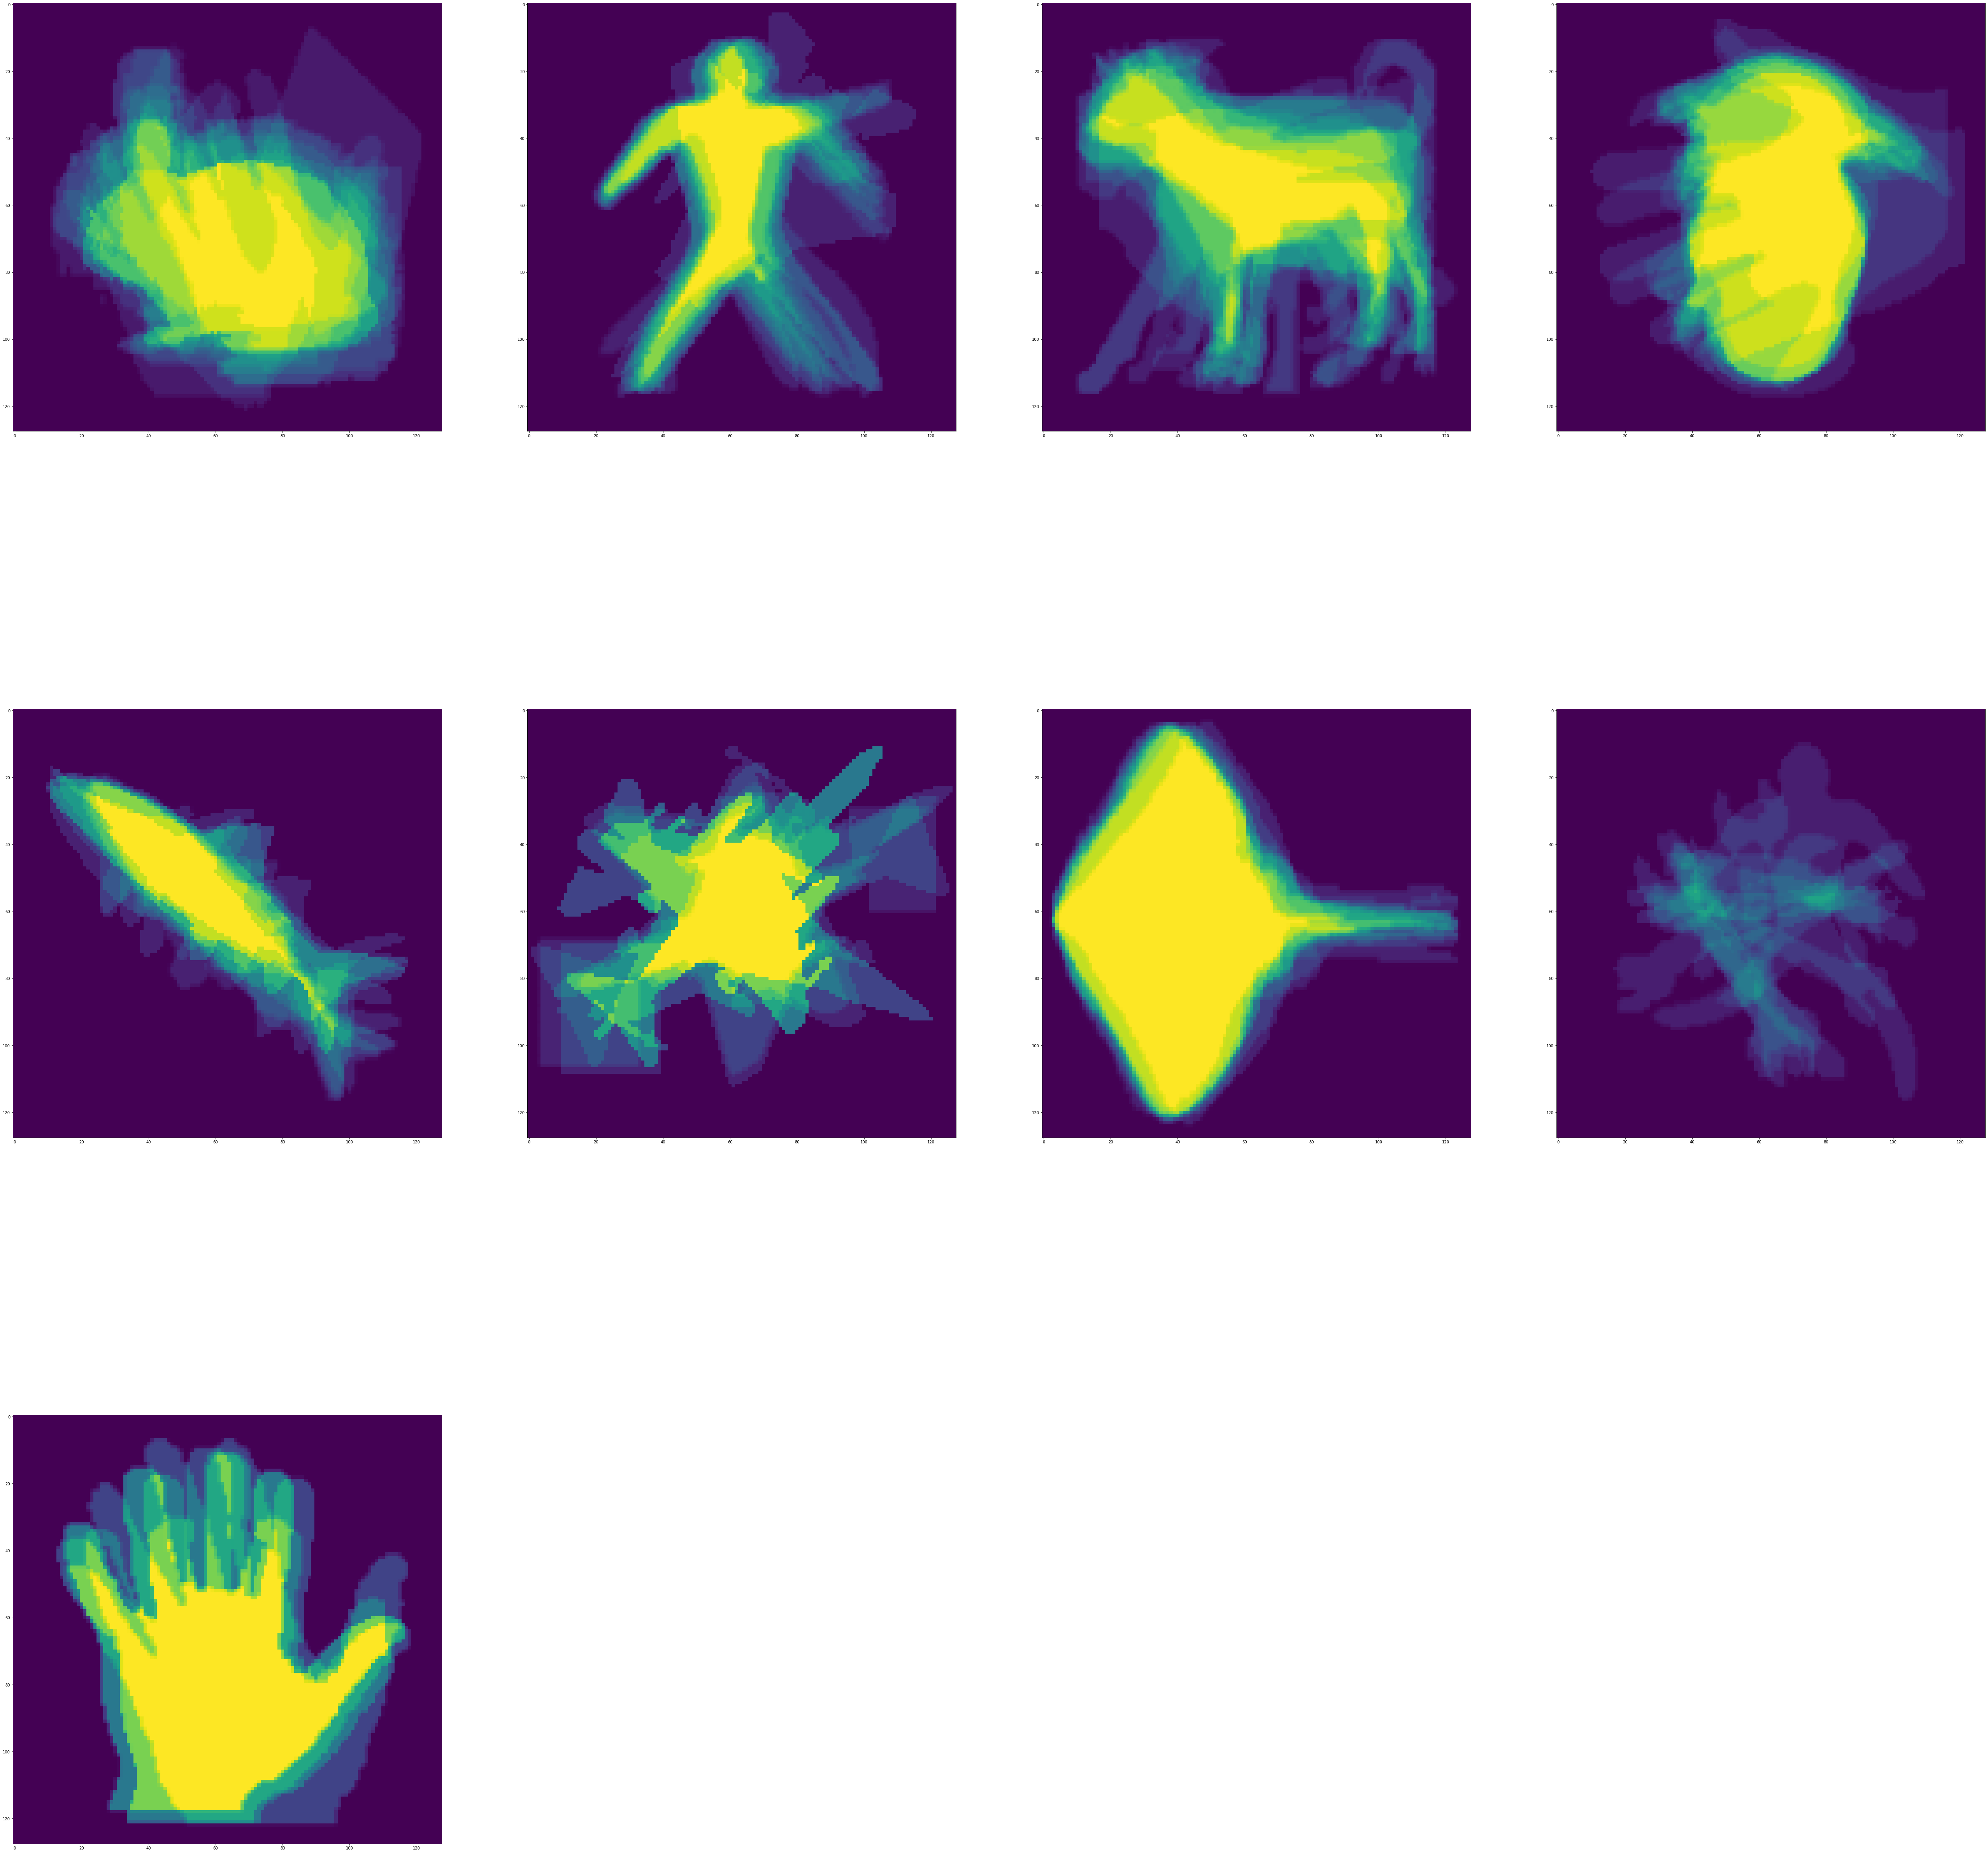

In [23]:
# Reshaping input data back
centroids = centroids.reshape(9,128,128)
# nullify normalization
centroids = centroids / 255
plt.figure(figsize = (128,128))
bottom = 0.35
for i in range(9):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(centroids[i],vmin=0,vmax=255)

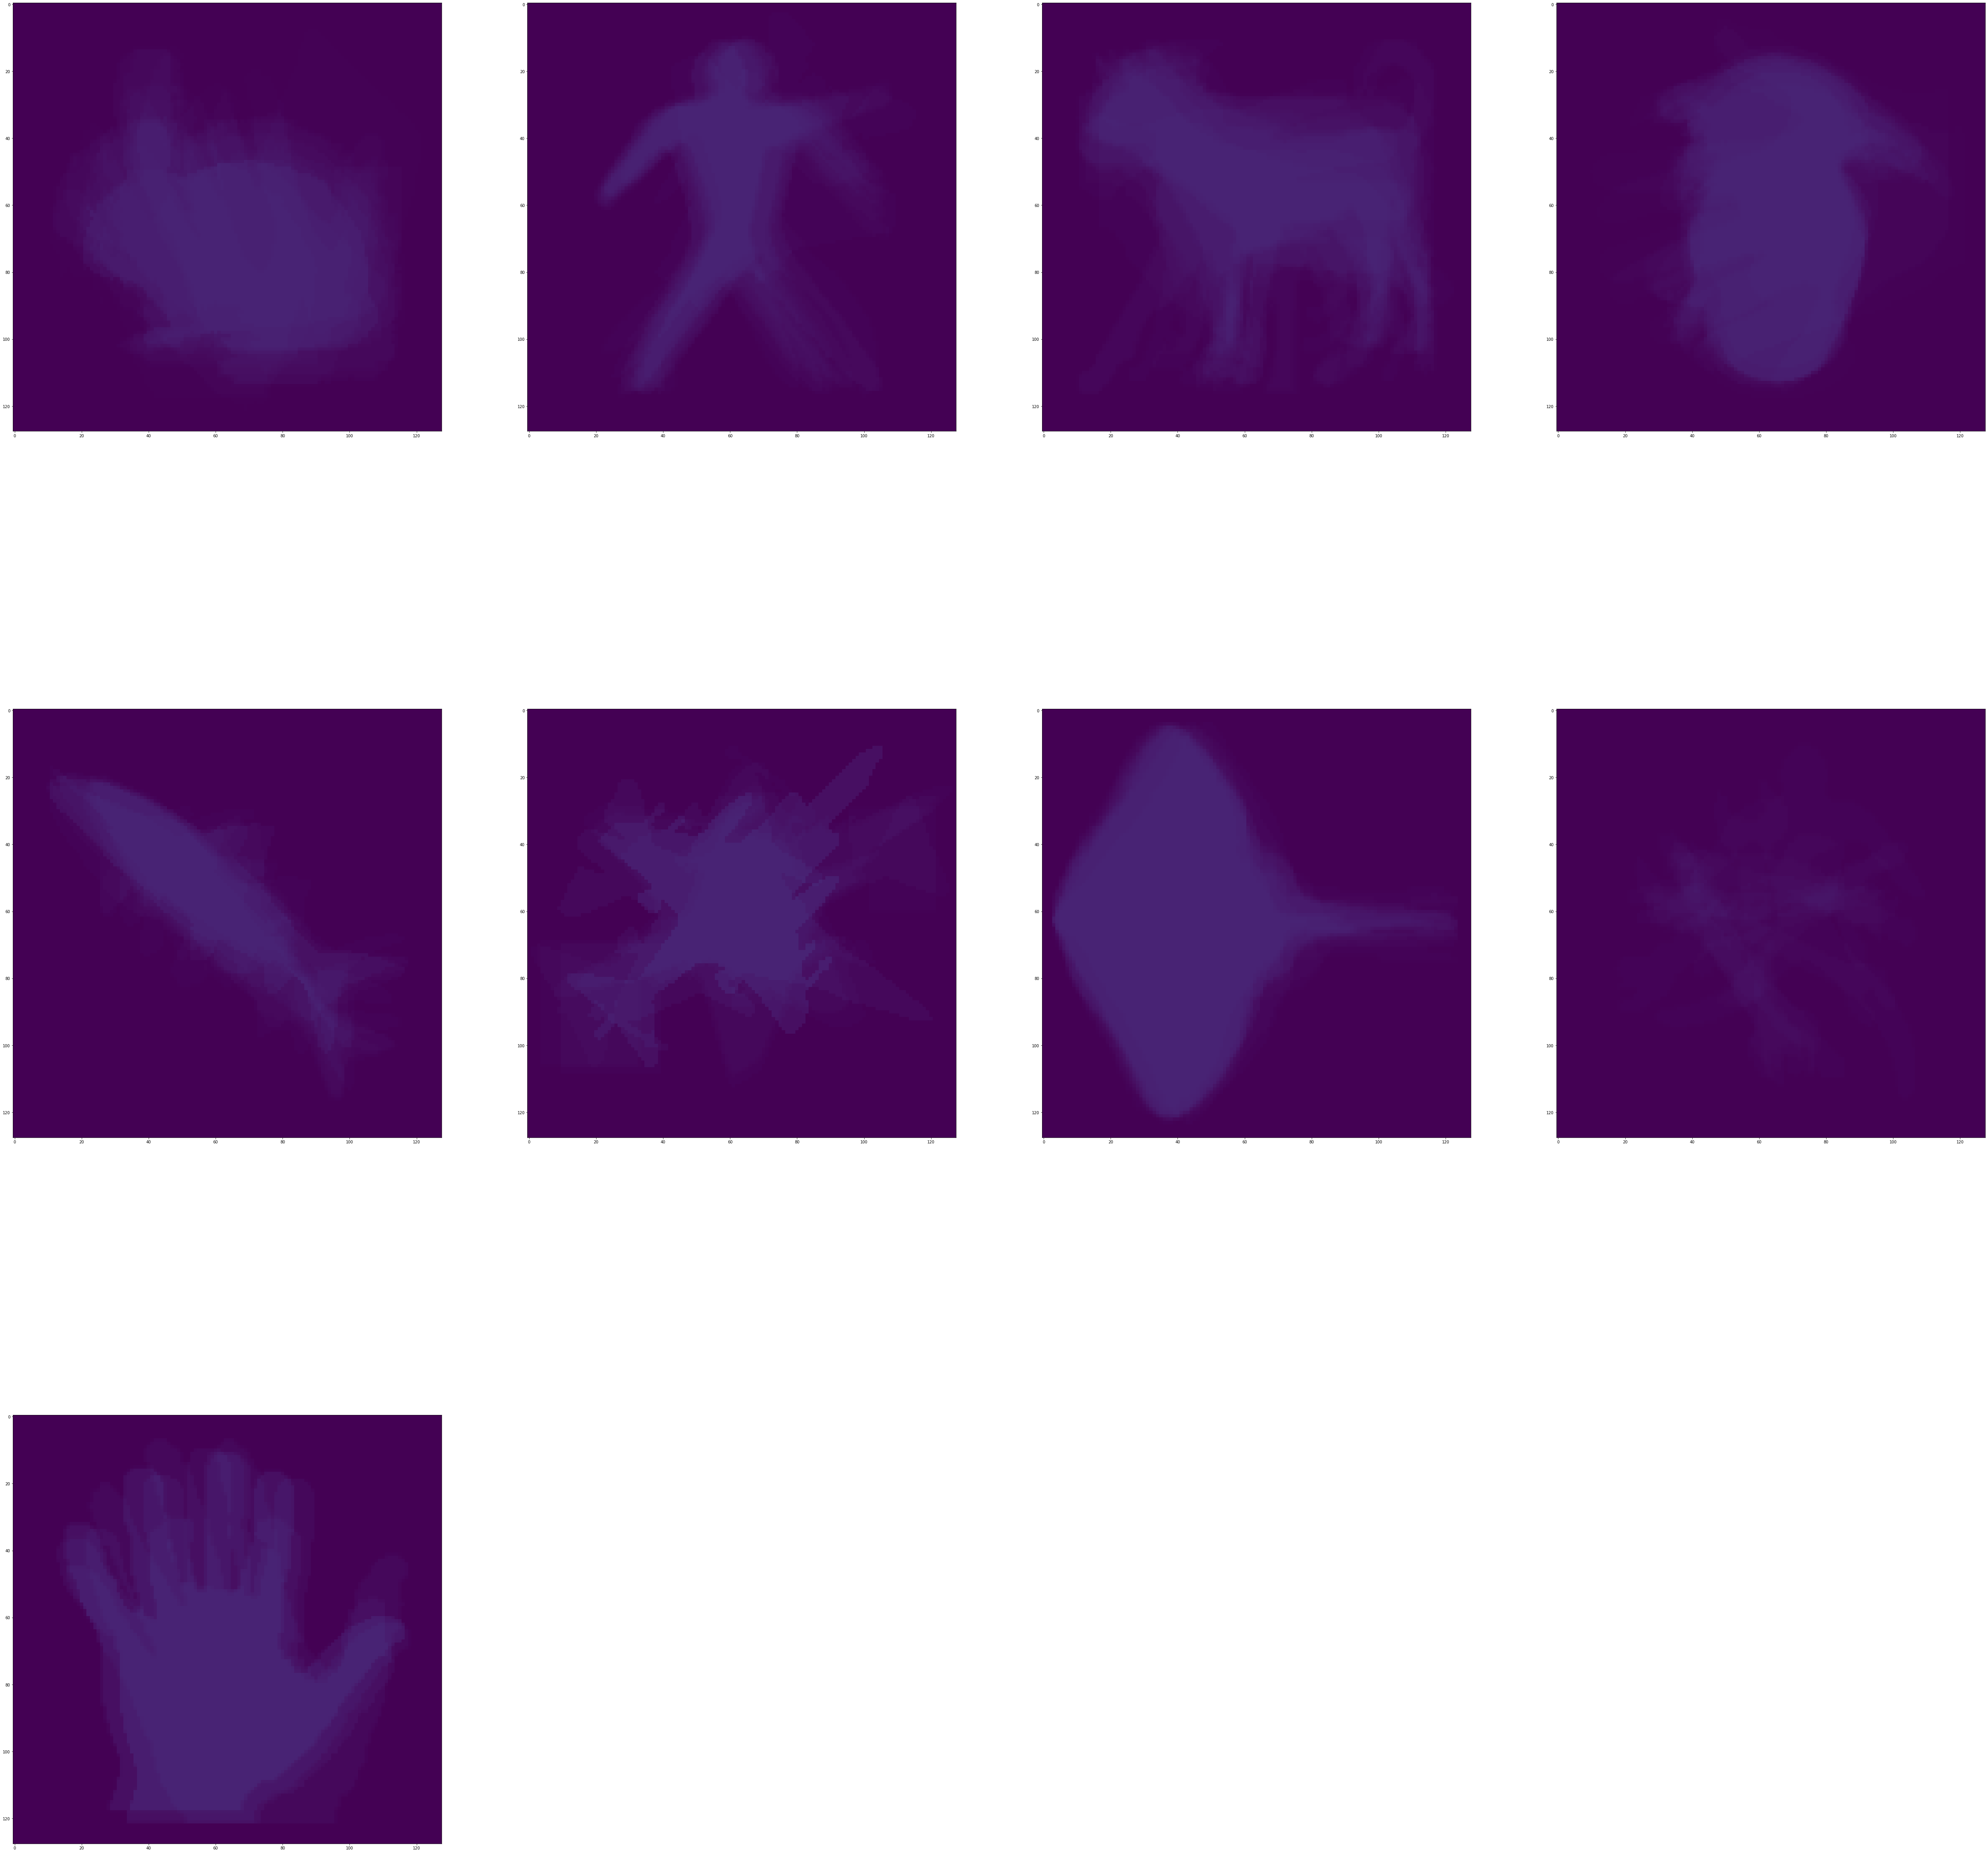

In [60]:
#centroids = centroids /10
bottom = 0.35
plt.figure(figsize = (128,128))
for i in range(9):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(centroids[i],vmin=0,vmax=255)

### traditional K-means with another random state

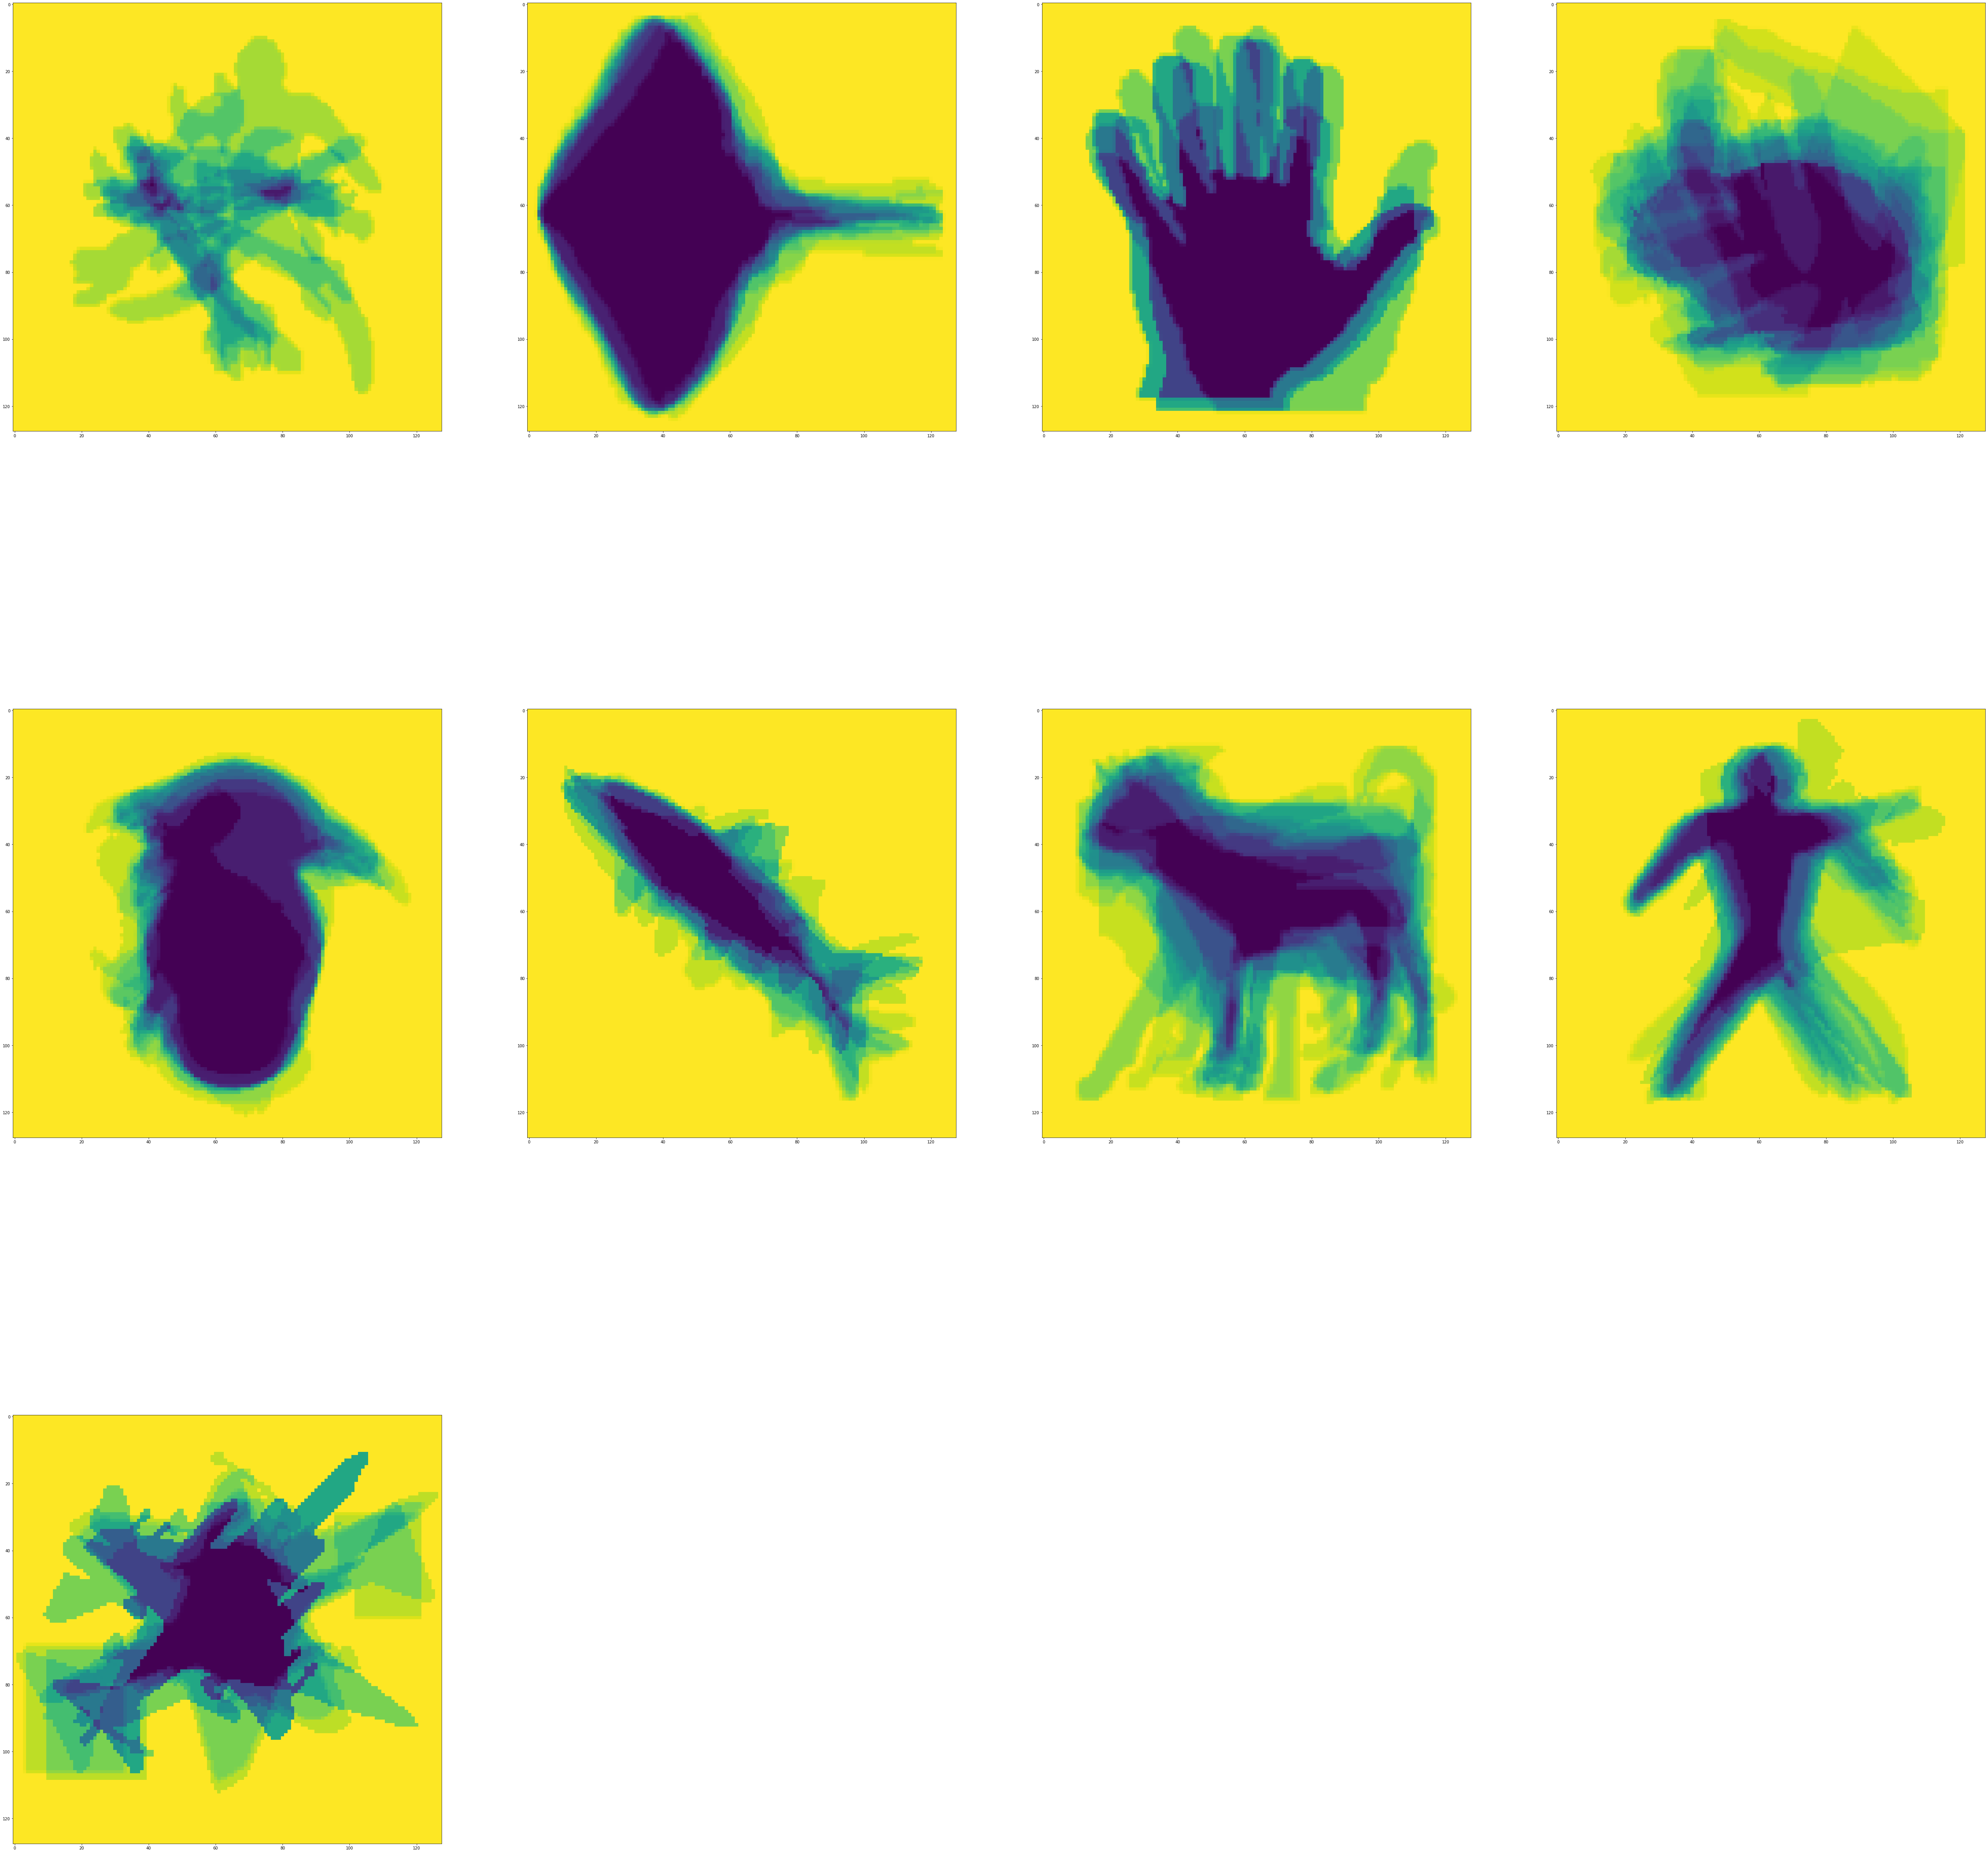

In [16]:
from sklearn.cluster import KMeans
total_clusters = 9
# Initialize the K-Means model
kmeans = KMeans(n_clusters = total_clusters, random_state=5)
# Fitting the model to training set
kmeans.fit(all_img)
centroids = kmeans.cluster_centers_

# Reshaping input data back
centroids = centroids.reshape(9,128,128)
# nullify normalization
centroids = centroids * 255
plt.figure(figsize = (128,128))
bottom = 0.35
for i in range(9):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(centroids[i])

### traditional K-means with more clusters

In [11]:
total_clusters = 15
# Initialize the K-Means model
kmeans1 = KMeans(n_clusters = total_clusters, random_state = 0)
# Fitting the model to training set
kmeans1.fit(all_img)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

(15, 16384)


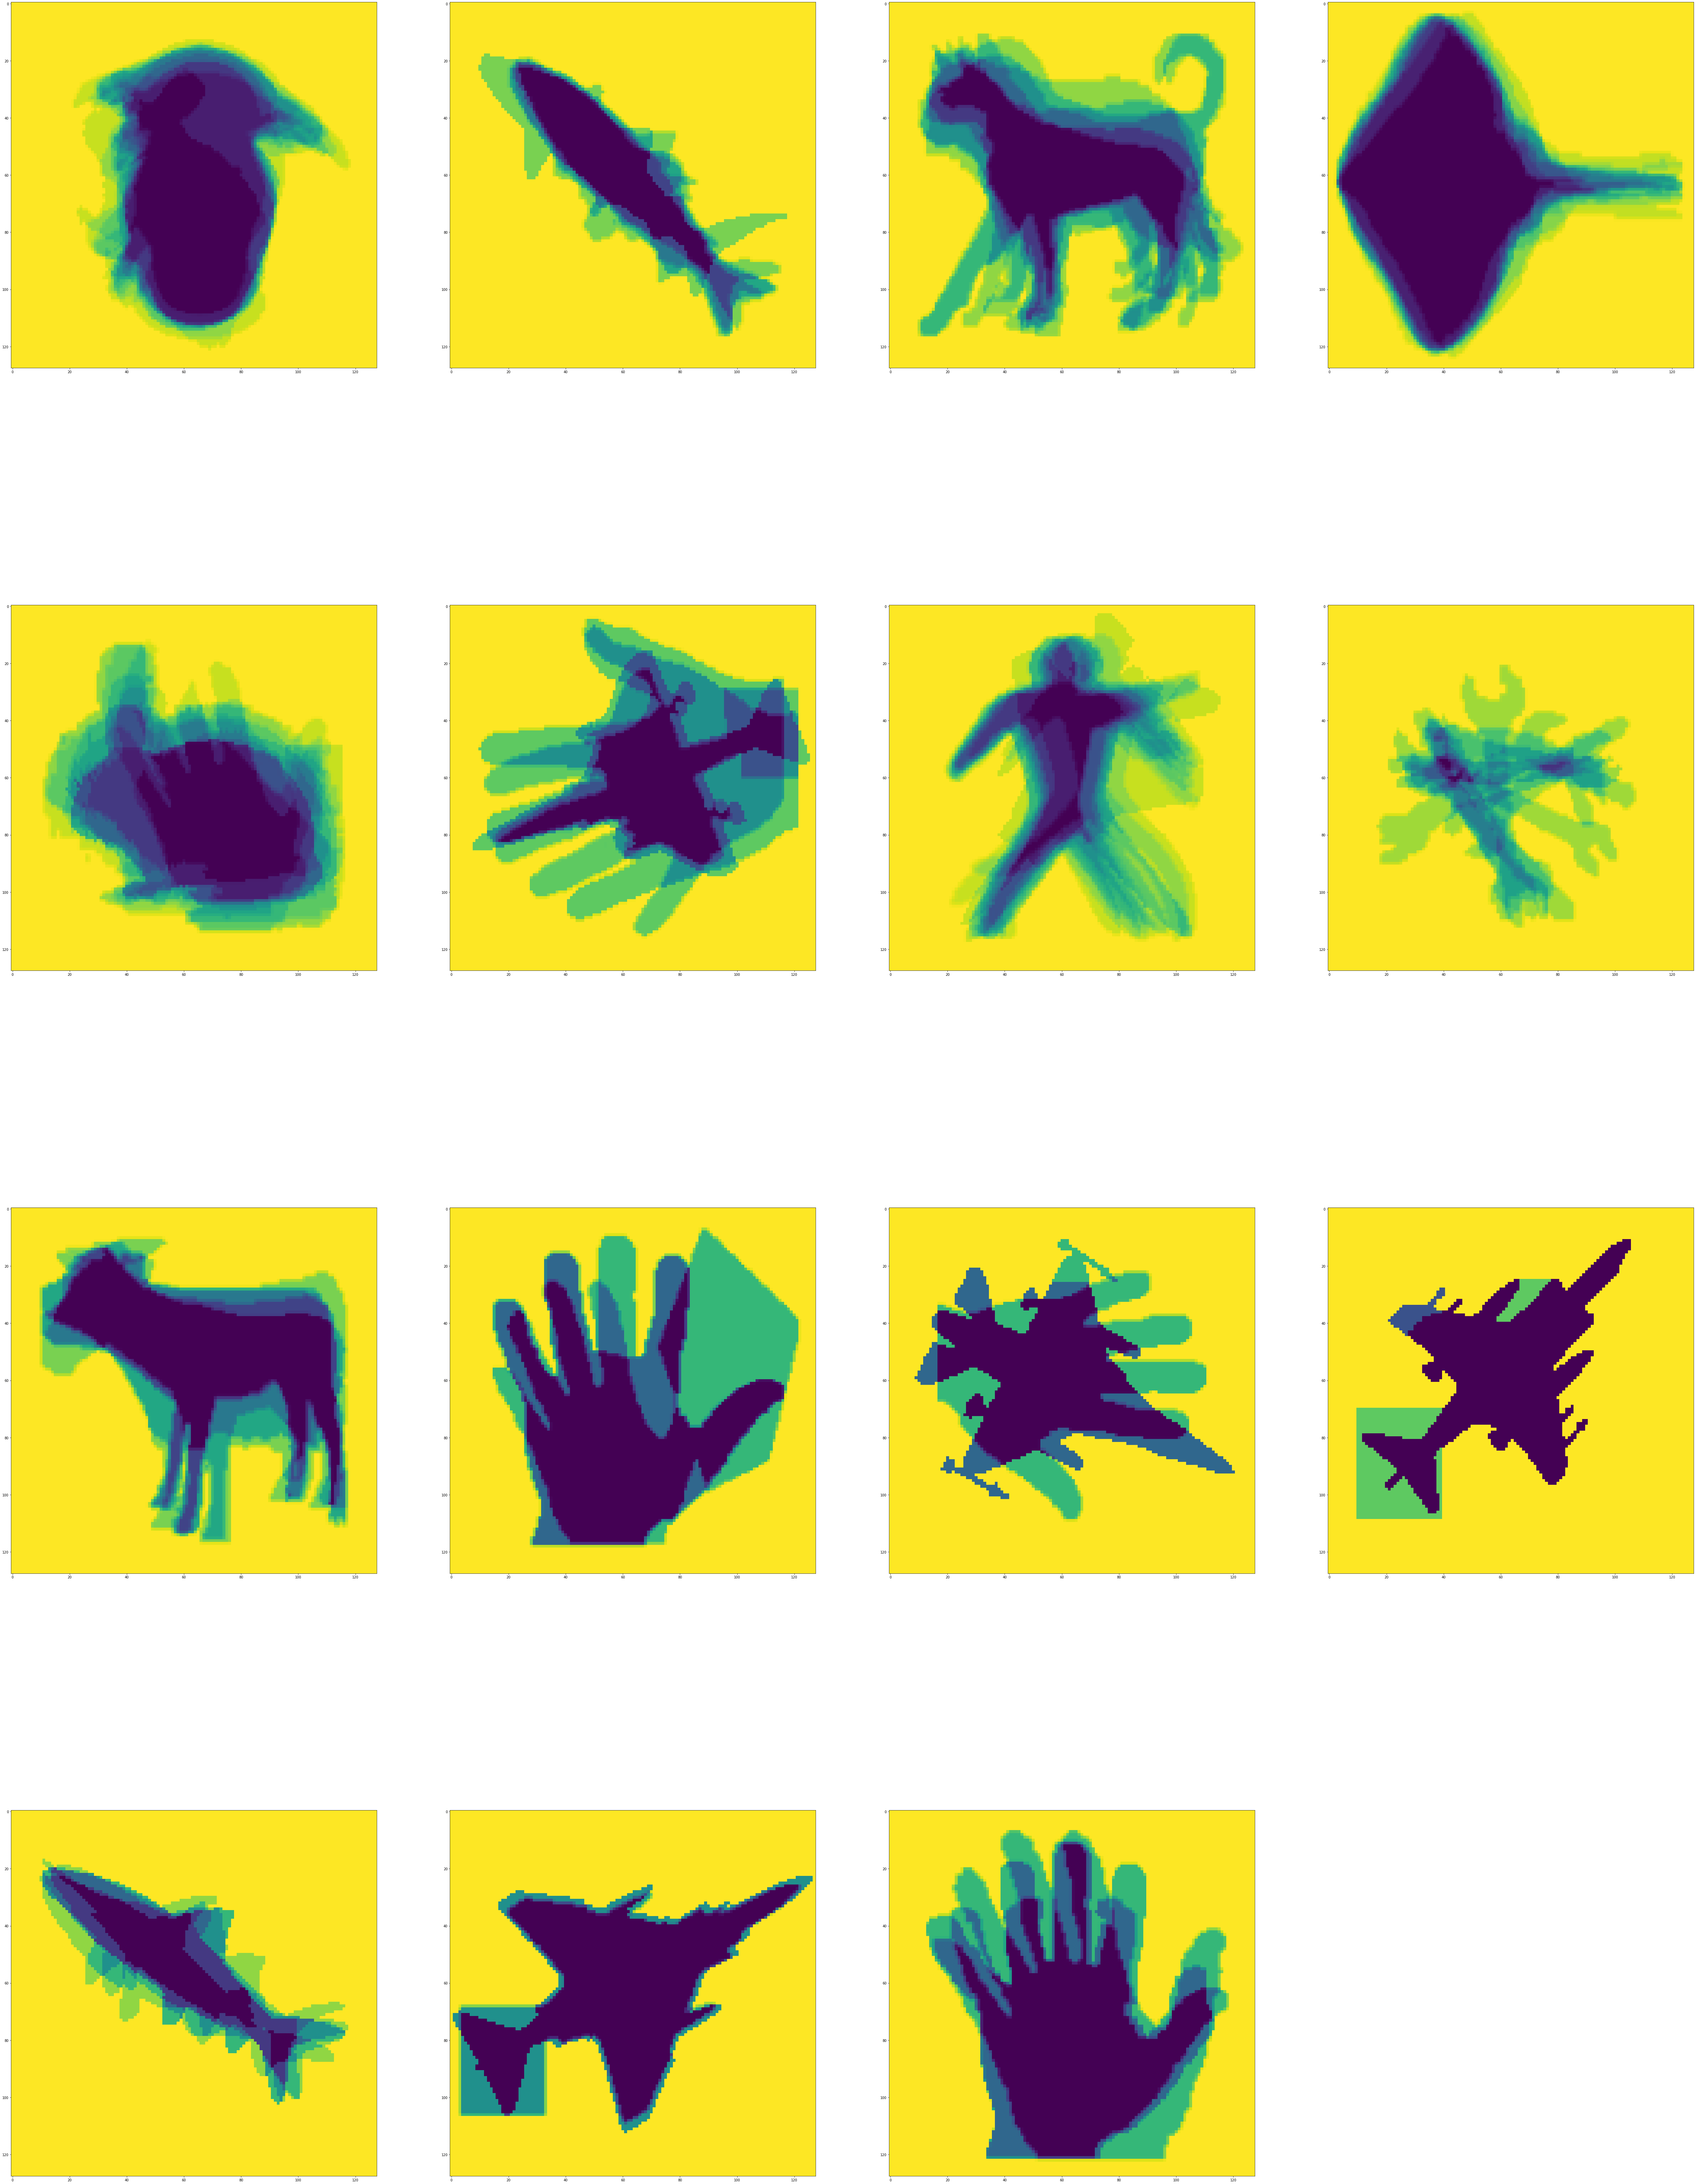

In [13]:
centroids1 = kmeans1.cluster_centers_
print(centroids1.shape)
# Reshaping input data back
centroids1 = centroids1.reshape(total_clusters,128,128)
# nullify normalization
centroids1 = centroids1 * 255
plt.figure(figsize = (128,128))
bottom = 0.35
for i in range(total_clusters):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(centroids1[i])

#### Note: Pretty accurate clustering result with random_state = 5 for pokemon, fish, cow, stingray, man, hand. But centroid for fish, cow, man, hand are all blurred.

### K-Means with Wasserstein Distance

In [46]:
import ot
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import math

In [47]:
# Load images
# Define path to the data directory
data_dir = Path('/Users/carollong/Desktop/OptimalTransport/ShapeProject/Data/SmallSet')
all_dir = [f for f in data_dir.glob("*.*")]

# Reshape to size dim x dim 
dim = 25

all_img = []
# Process each img
for direc in all_dir:
    temp = plt.imread(direc, 0)
    #convert to greyscale
    if len(temp.shape)>2:
        temp = temp[:,:,2]
    temp = cv2.resize(temp, (dim,dim))
    # Normalization, so that each temp is a distribution
    temp = temp / np.sum(temp)
    temp = temp.flatten()
    all_img.append(temp)
# Shuffle lists
random.shuffle(all_img)

In [48]:
# cost matrix: dim^2 by dim^2
M = []
# dim same as above
for i in range(dim):
    for j in range(dim):
        for m in range(dim):
            for n in range(dim):
                M.append(math.pow(i-m,2)+math.pow(j-n,2))
M = np.reshape(M, (dim*dim,dim*dim))
M = np.array(M)

In [49]:
# Initialize k centroids of size 1 x dim^2, by picking k samples randomly
# Number of clusters
k = 9
all_img = np.array(all_img)
# Randomly pick k centroids from dataset
np.random.seed = 5
rdm_idx = np.random.choice(range(all_img.shape[0]), k, replace=False)
W = all_img[rdm_idx,:]
print("W shape:", W.shape)


W shape: (9, 625)


In [ ]:
def slicedWDist(miu,eta):
    """miu - dim b

In [101]:
# assign clusters
def expectation(X, W, dist, regularization = 2):
    '''
    X: N x d instead
    W: k x d instead
    dist: "euclidean" or "wasserstein"
    '''
    # Get shapes
    N, d = X.shape
    k, _ = W.shape
    if dist == "wasserstein":
        # Compute Distance and assign cluster in one step
        cluster_id = [] # N x 1
        # Compute distances from each sample to each cluster 
        for i in range(N):
            minDist = float('inf')
            index = -1
            for j in range(k):
                # !!!use sliced W-2 Distance to calculate wasserstein dist
                tempdist = ot.bregman.sinkhorn2(X[i],W[j],M ,reg = regularization) 
                print(tempdist)
                if tempdist<minDist:
                    minDist = tempdist
                    index = j
            cluster_id.append(index)

        cluster_id = np.array(cluster_id)
    else:
        # Reshape inputs to use broadcasting
        X_exp = X.reshape(N, 1, d)  
        W_exp = W.reshape(1, k, d) 
        # Compute distances from each sample to each cluster
        distances = np.linalg.norm(X_exp - W_exp, axis=2) # N x k
        # Obtain cluster assignements
        cluster_id = np.argmin(distances, axis=1)
        
    # Matrix of one-hot vectors
    Z = np.zeros((N, k))
    Z[range(N),cluster_id] = 1 
    return Z

In [102]:
# get class assignments
Z = expectation(all_img, W,dist = "wasserstein")
Z.shape
print(Z)

[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]

[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]

[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]

[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]

[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]

[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]
[0.00479444]

### Maximization Step

In [103]:
def maximization(X, Z, dist, reg = 2):
    '''
    X: N x d
    Z: N x k
    dist: "euclidean" or "wasserstein"
    '''
    # Get shapes
    N, d = X.shape
    _, k = Z.shape
    # Compute updated centroids
    W_new = np.zeros((k, d))
    if dist == "wasserstein":
        for cl_id in range(k):
            tempClass = X[(Z[: ,cl_id] == 1), :]
            #print(tempClass.shape)
            countInClass = len(tempClass)
            # equal weights by default
            W_new[cl_id,:] = ot.bregman.barycenter_sinkhorn(np.transpose(tempClass), M, reg = reg)
    else:
        for cl_id in range(k):
            W_new[cl_id, :] = np.mean(X[(Z[: ,cl_id] == 1), :], axis=0)
    return W_new

(2, 2500)
[0.00039841 0.00048143 0.0004664  ... 0.00046392 0.00047986 0.00039694]


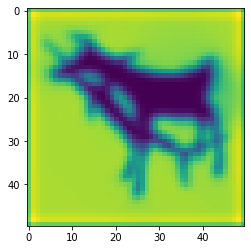

In [106]:
# all_img 4 and 6 are both hands
smallset = np.append([all_img[4]], [all_img[6]], axis = 0)
print(smallset.shape)
centroid = ot.bregman.barycenter_sinkhorn(np.transpose(smallset),M,2)
print(centroid)
plt.imshow(centroid.reshape(dim,dim))


In [81]:
print(Z.shape)
print(all_img.shape)
print(M.shape)

(18, 9)
(18, 625)
(625, 625)


In [82]:
# get class assignments
W = maximization(all_img, Z,dist = "wasserstein")


### Combine E-M step to run K-Means

In [69]:
def run_kmeans(X, K, dist1, dist2, max_iter = 100, eps = 1e-5, log_interval = 2):
    
    rdm_idx = np.random.choice(range(X.shape[0]), K, replace=False)
    W = X[rdm_idx,:]
    Z = None
    
    # Expectation-maximization loop
    for n_iter in range(max_iter):
        # Store previous W and Z
        Z_prev = Z
        W_prev = W
        
        # Expectation followed by maximization step
        Z = expectation(X, W, dist = dist1)
        W = maximization(X, Z, dist = dist2)

        # Terminate if change in Z and W is small
        if Z_prev is not None and ((Z_prev - Z) ** 2).sum() < eps and ((W_prev - W) ** 2).sum() < eps:
            print('Done at iteration: ', n_iter + 1)
            rec_error = np.linalg.norm(X - Z @ W, axis=1).sum() 
            print ('Reconstruction error ', n_iter + 1,":", rec_error)
            break

        # Print reconstruction loss every log_interval steps    
        if (n_iter + 1) % log_interval == 0 or (n_iter + 1) == max_iter or n_iter == 0:
            rec_error = np.linalg.norm(X - Z @ W, axis=1).sum()
            print ('Reconstruction error at iteration ', n_iter + 1,":", rec_error)
            
    # Visualize with Wasserstein barycenter. 
    
    return W, Z, rec_error

In [54]:
W, Z, rec_error = run_kmeans(all_img, K=9, dist1 = "wasserstein", dist2 = "wasserstein")

Reconstruction error at iteration  1 : 0.1486774212945438
Done at iteration:  2
Reconstruction error  2 : 0.1486774212945438


In [55]:
W2, Z2, rec_error2 = run_kmeans(all_img, K=9, dist1 = "euclidean", dist2 = "euclidean")

Reconstruction error at iteration  1 : 0.11214081230853826
Done at iteration:  2
Reconstruction error  2 : 0.11214081230853826


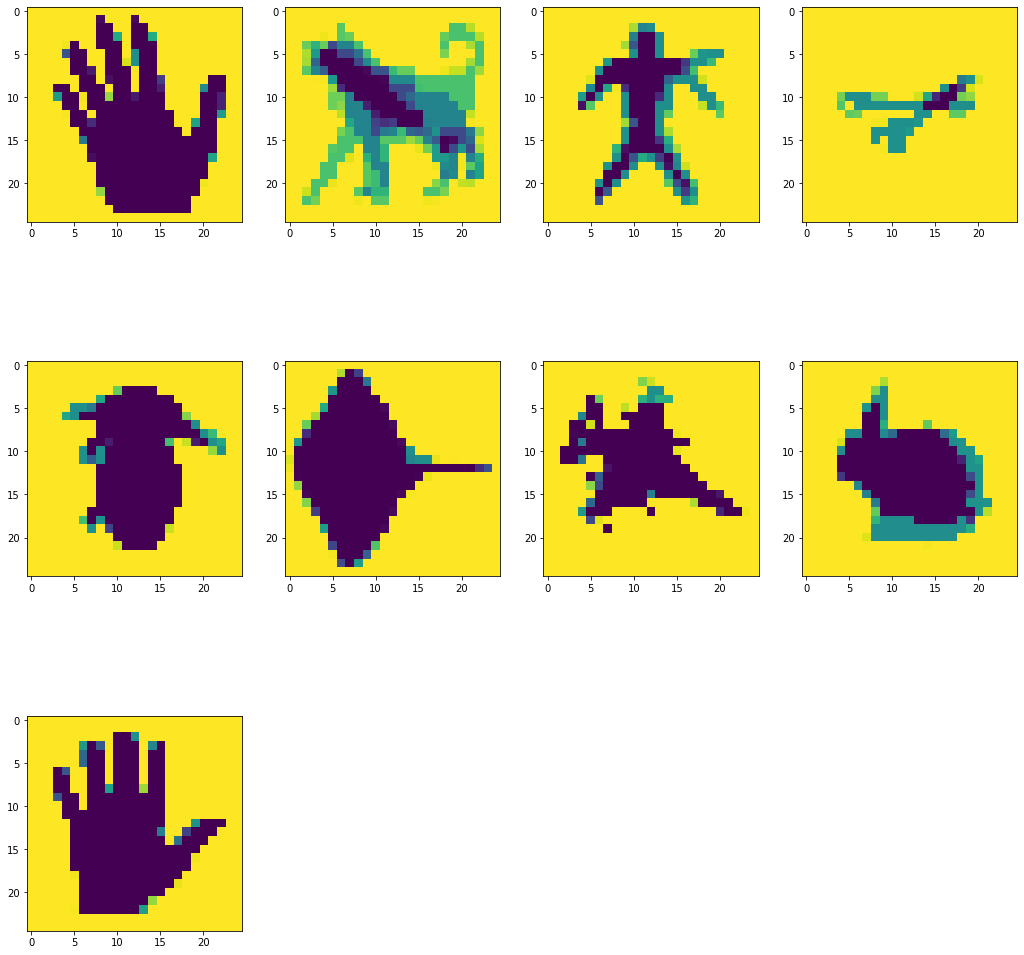

In [56]:
# visualize euclidean centroid
# Reshaping input data back
W2 = W2.reshape(k,dim,dim)
plt.figure(figsize = (dim,dim))
bottom = 0.35
for i in range(k):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(W2[i])

In [105]:
print(Z2)

[[0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]


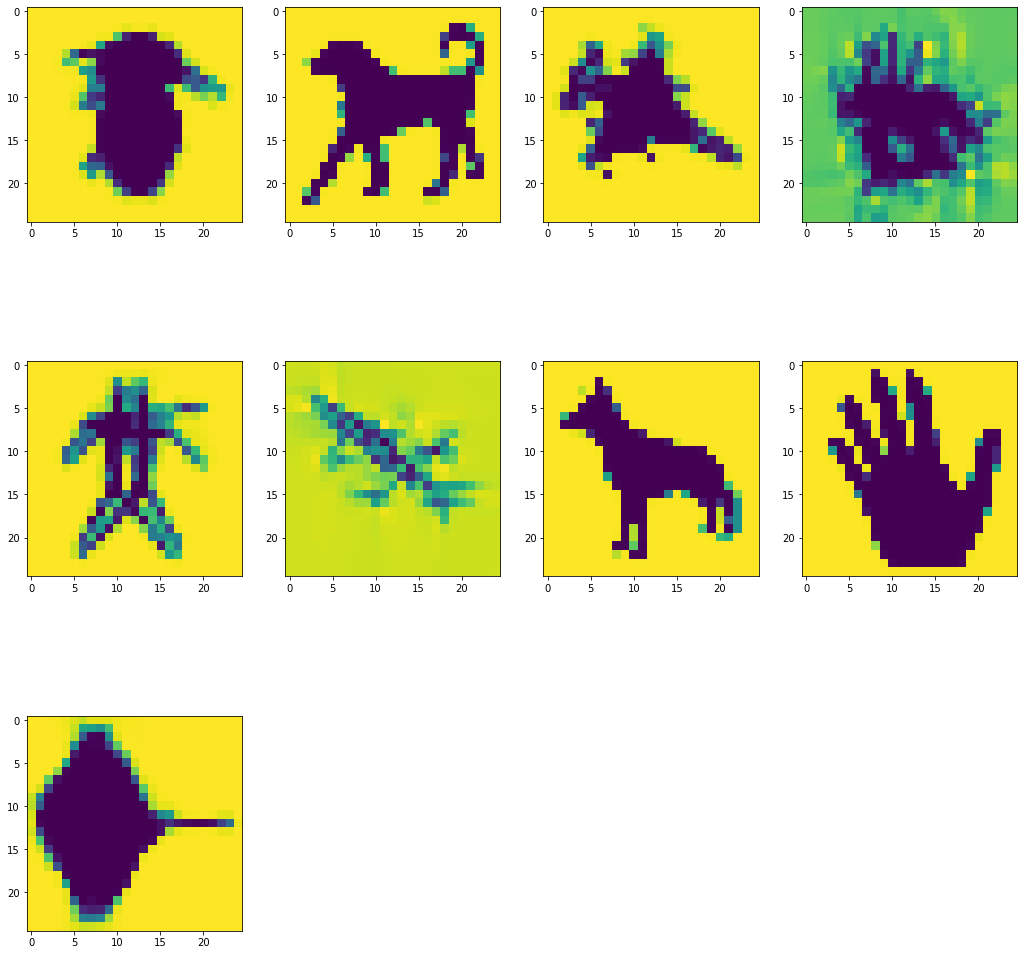

In [58]:
# visialize W (centroids)
# Reshaping input data back
W = W.reshape(k,dim,dim)
plt.figure(figsize = (dim,dim))
bottom = 0.35
for i in range(k):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(W[i],vmax=np.max(W[i]),vmin = 0)

In [29]:
W1, Z1, rec_error = run_kmeans(all_img, K=9, max_iter = 100)

Reconstruction error at iteration  1 : 0.6853054670543376
Reconstruction error at iteration  2 : 0.6473968573240005
Reconstruction error at iteration  4 : 0.6282602828547004
Reconstruction error at iteration  6 : 0.6195276300660262
Reconstruction error at iteration  8 : 0.6199109577445906
Reconstruction error at iteration  10 : 0.6146369543935656
Reconstruction error at iteration  12 : 0.6100982867730866
Reconstruction error at iteration  14 : 0.5990351242290031
Done at iteration:  15
Reconstruction error  15 : 0.5990351242290031


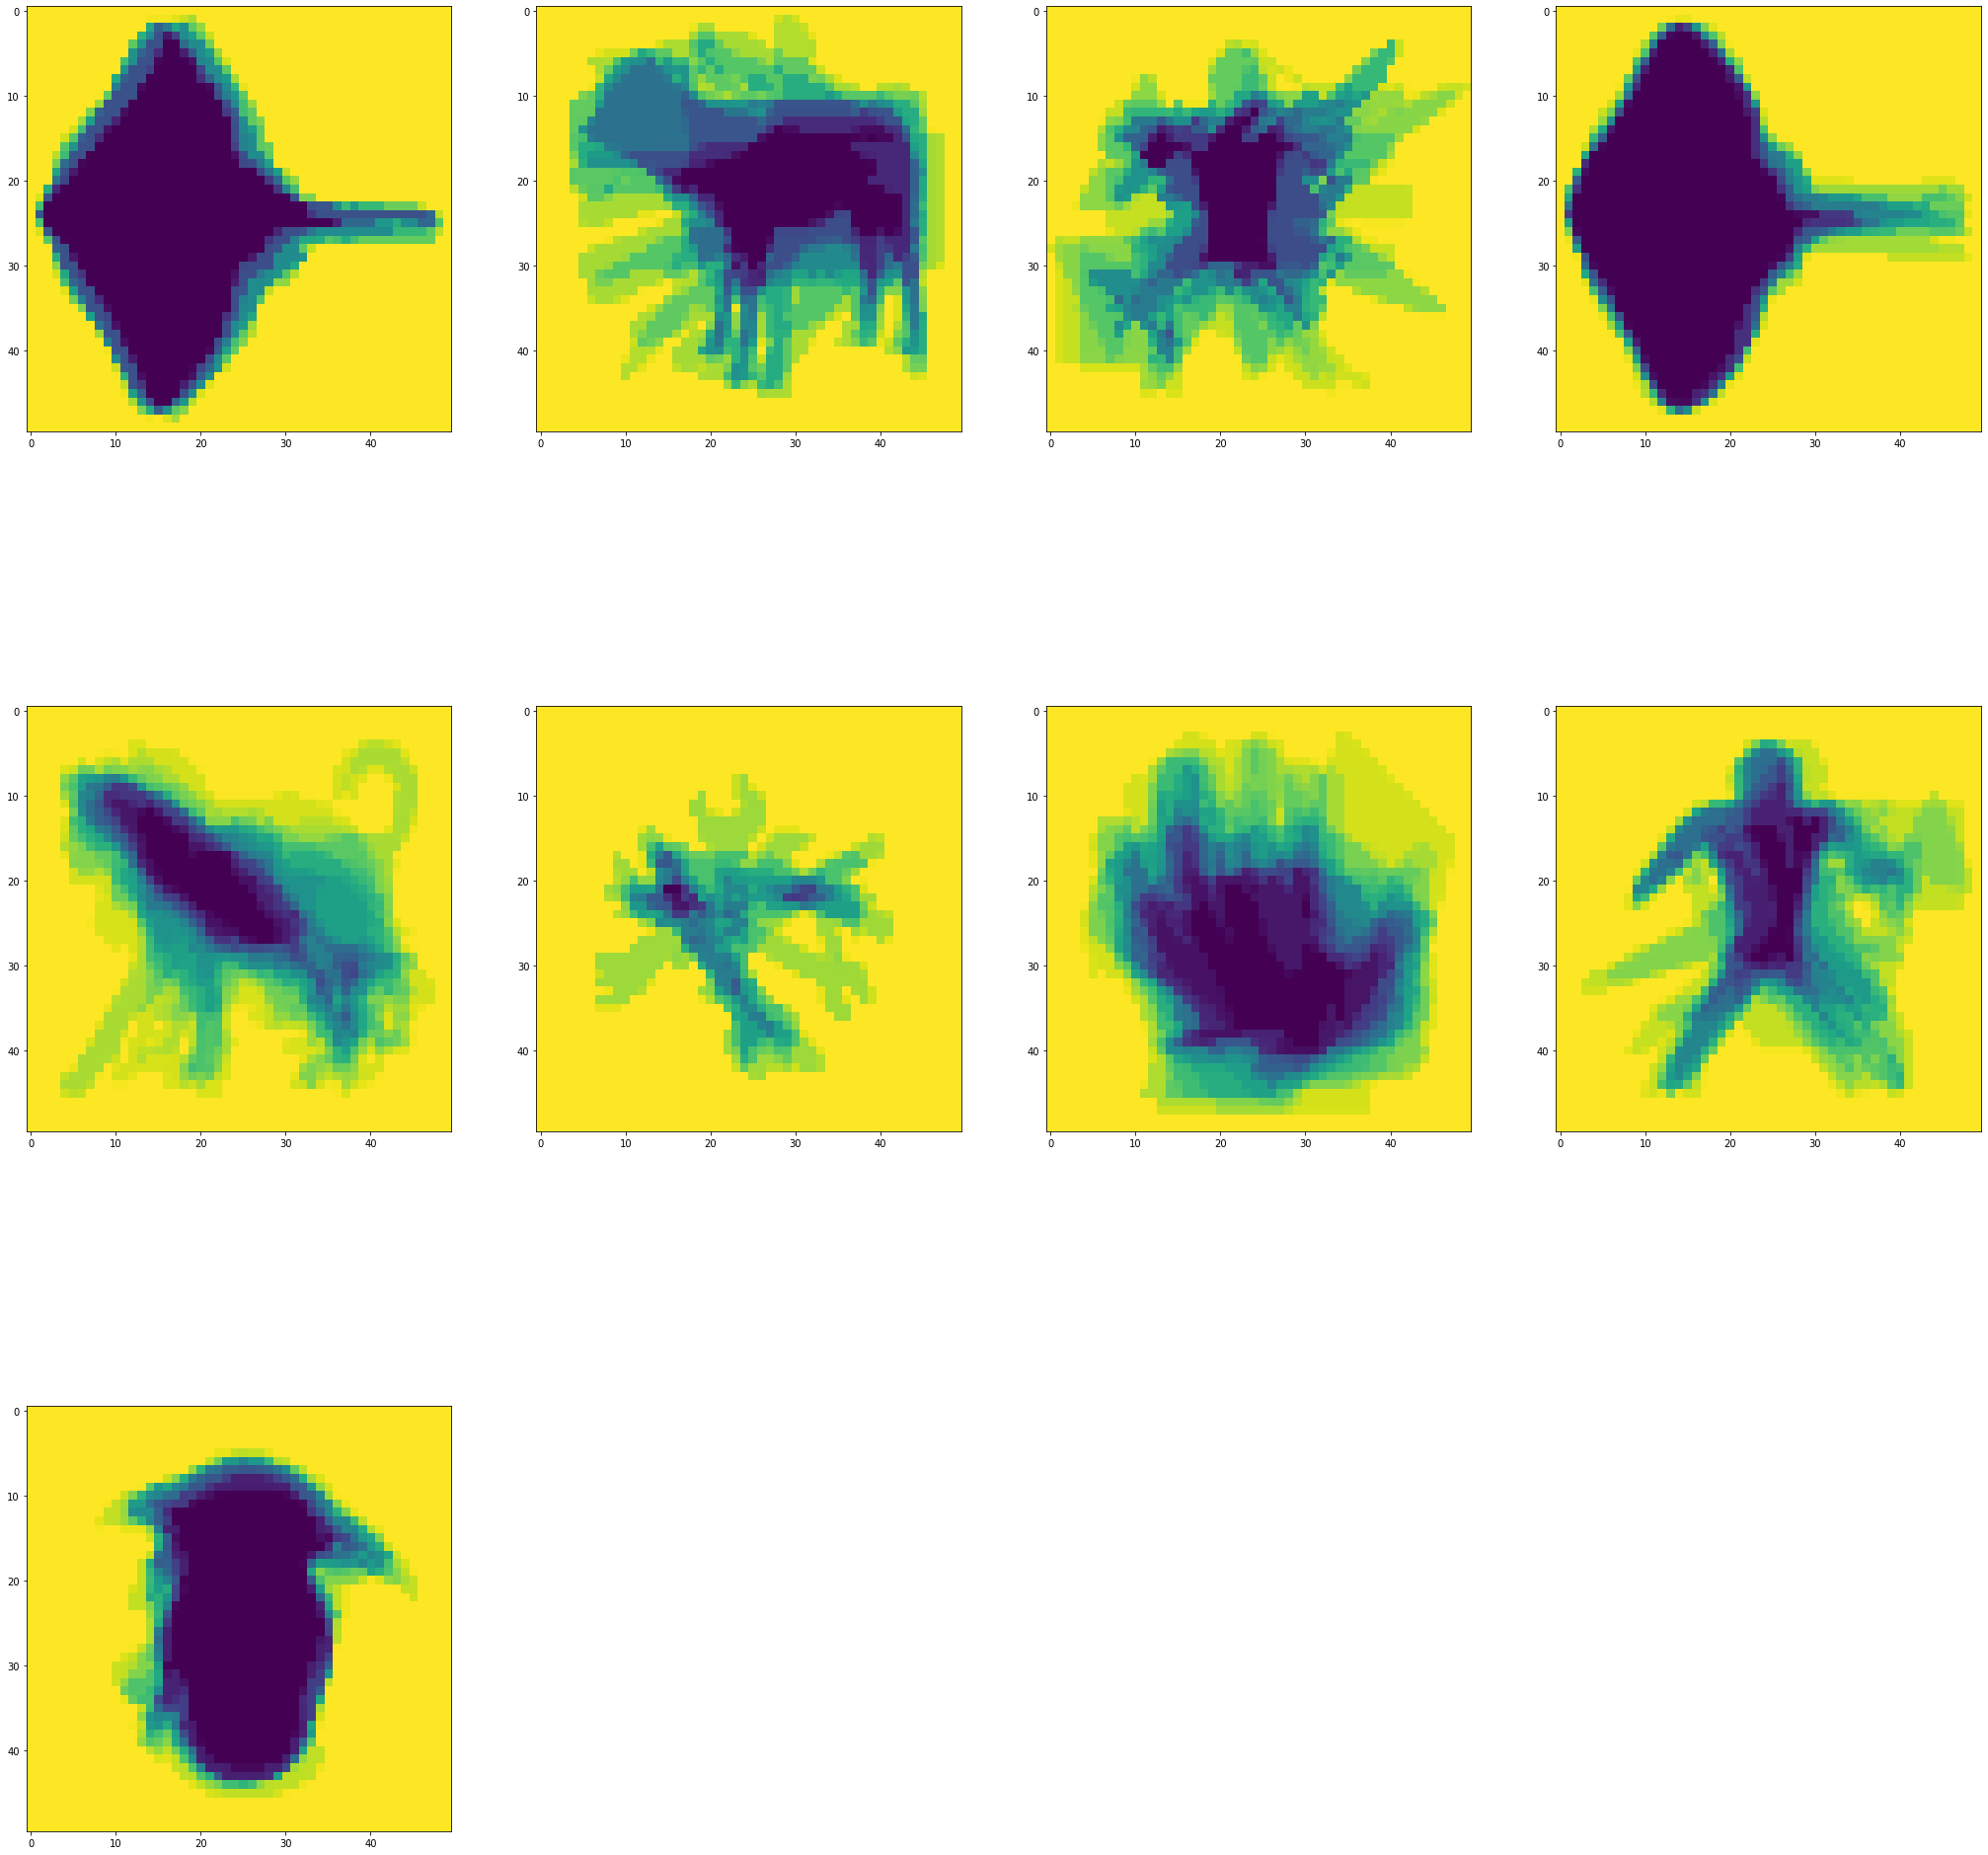

In [30]:
# visialize W (centroids)
# Reshaping input data back
W1 = W1.reshape(k,dim,dim)
plt.figure(figsize = (dim,dim))
bottom = 0.35
for i in range(k):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(W[i])

### Use all 99 images

In [71]:
# Load images
# Define path to the data directory
data_dir = Path('/Users/carollong/Desktop/OptimalTransport/ShapeProject/Data')
all_dir = [f for f in data_dir.glob("*.*")]

# Reshape to size dim x dim 
dim = 50

all_img = []
# Process each img
for direc in all_dir:
    temp = plt.imread(direc, 0)
    #convert to greyscale
    if len(temp.shape)>2:
        temp = temp[:,:,2]
    temp = cv2.resize(temp, (dim,dim))
    # Normalization, so that each temp is a distribution
    temp = temp / np.sum(temp)
    temp = temp.flatten()
    all_img.append(temp)
# Shuffle lists
random.shuffle(all_img)

In [72]:
# cost matrix: dim^2 by dim^2
M = []
# dim same as above
for i in range(dim):
    for j in range(dim):
        for m in range(dim):
            for n in range(dim):
                M.append(math.pow(i-m,2)+math.pow(j-n,2))
M = np.reshape(M, (dim*dim,dim*dim))
M = np.array(M)

In [97]:
# Initialize k centroids of size 1 x dim^2, by picking k samples randomly
# Number of clusters
k = 9
all_img = np.array(all_img)
# Randomly pick k centroids from dataset
np.random.seed = 7
rdm_idx = np.random.choice(range(all_img.shape[0]), k, replace=False)
W = all_img[rdm_idx,:]
print("W shape:", W.shape)


W shape: (9, 2500)


In [77]:
W4, Z4, rec_error = run_kmeans(all_img, K=9, dist1 = "euclidean", dist2 = "wasserstein")

Reconstruction error at iteration  1 : nan
Reconstruction error at iteration  2 : nan
Reconstruction error at iteration  4 : nan
Reconstruction error at iteration  6 : nan
Reconstruction error at iteration  8 : nan
Reconstruction error at iteration  10 : nan
Reconstruction error at iteration  12 : nan
Reconstruction error at iteration  14 : nan
Reconstruction error at iteration  16 : nan
Reconstruction error at iteration  18 : nan
Reconstruction error at iteration  20 : nan
Reconstruction error at iteration  22 : nan
Reconstruction error at iteration  24 : nan
Reconstruction error at iteration  26 : nan
Reconstruction error at iteration  28 : nan
Reconstruction error at iteration  30 : nan
Reconstruction error at iteration  32 : nan
Reconstruction error at iteration  34 : nan
Reconstruction error at iteration  36 : nan
Reconstruction error at iteration  38 : nan
Reconstruction error at iteration  40 : nan
Reconstruction error at iteration  42 : nan
Reconstruction error at iteration  44

In [98]:
W3, Z3, rec_error = run_kmeans(all_img, K=9, dist1 = "euclidean", dist2 = "euclidean")

Reconstruction error at iteration  1 : 0.6880650918180317
Reconstruction error at iteration  2 : 0.6222196739230988
Done at iteration:  4
Reconstruction error  4 : 0.6123159199022761


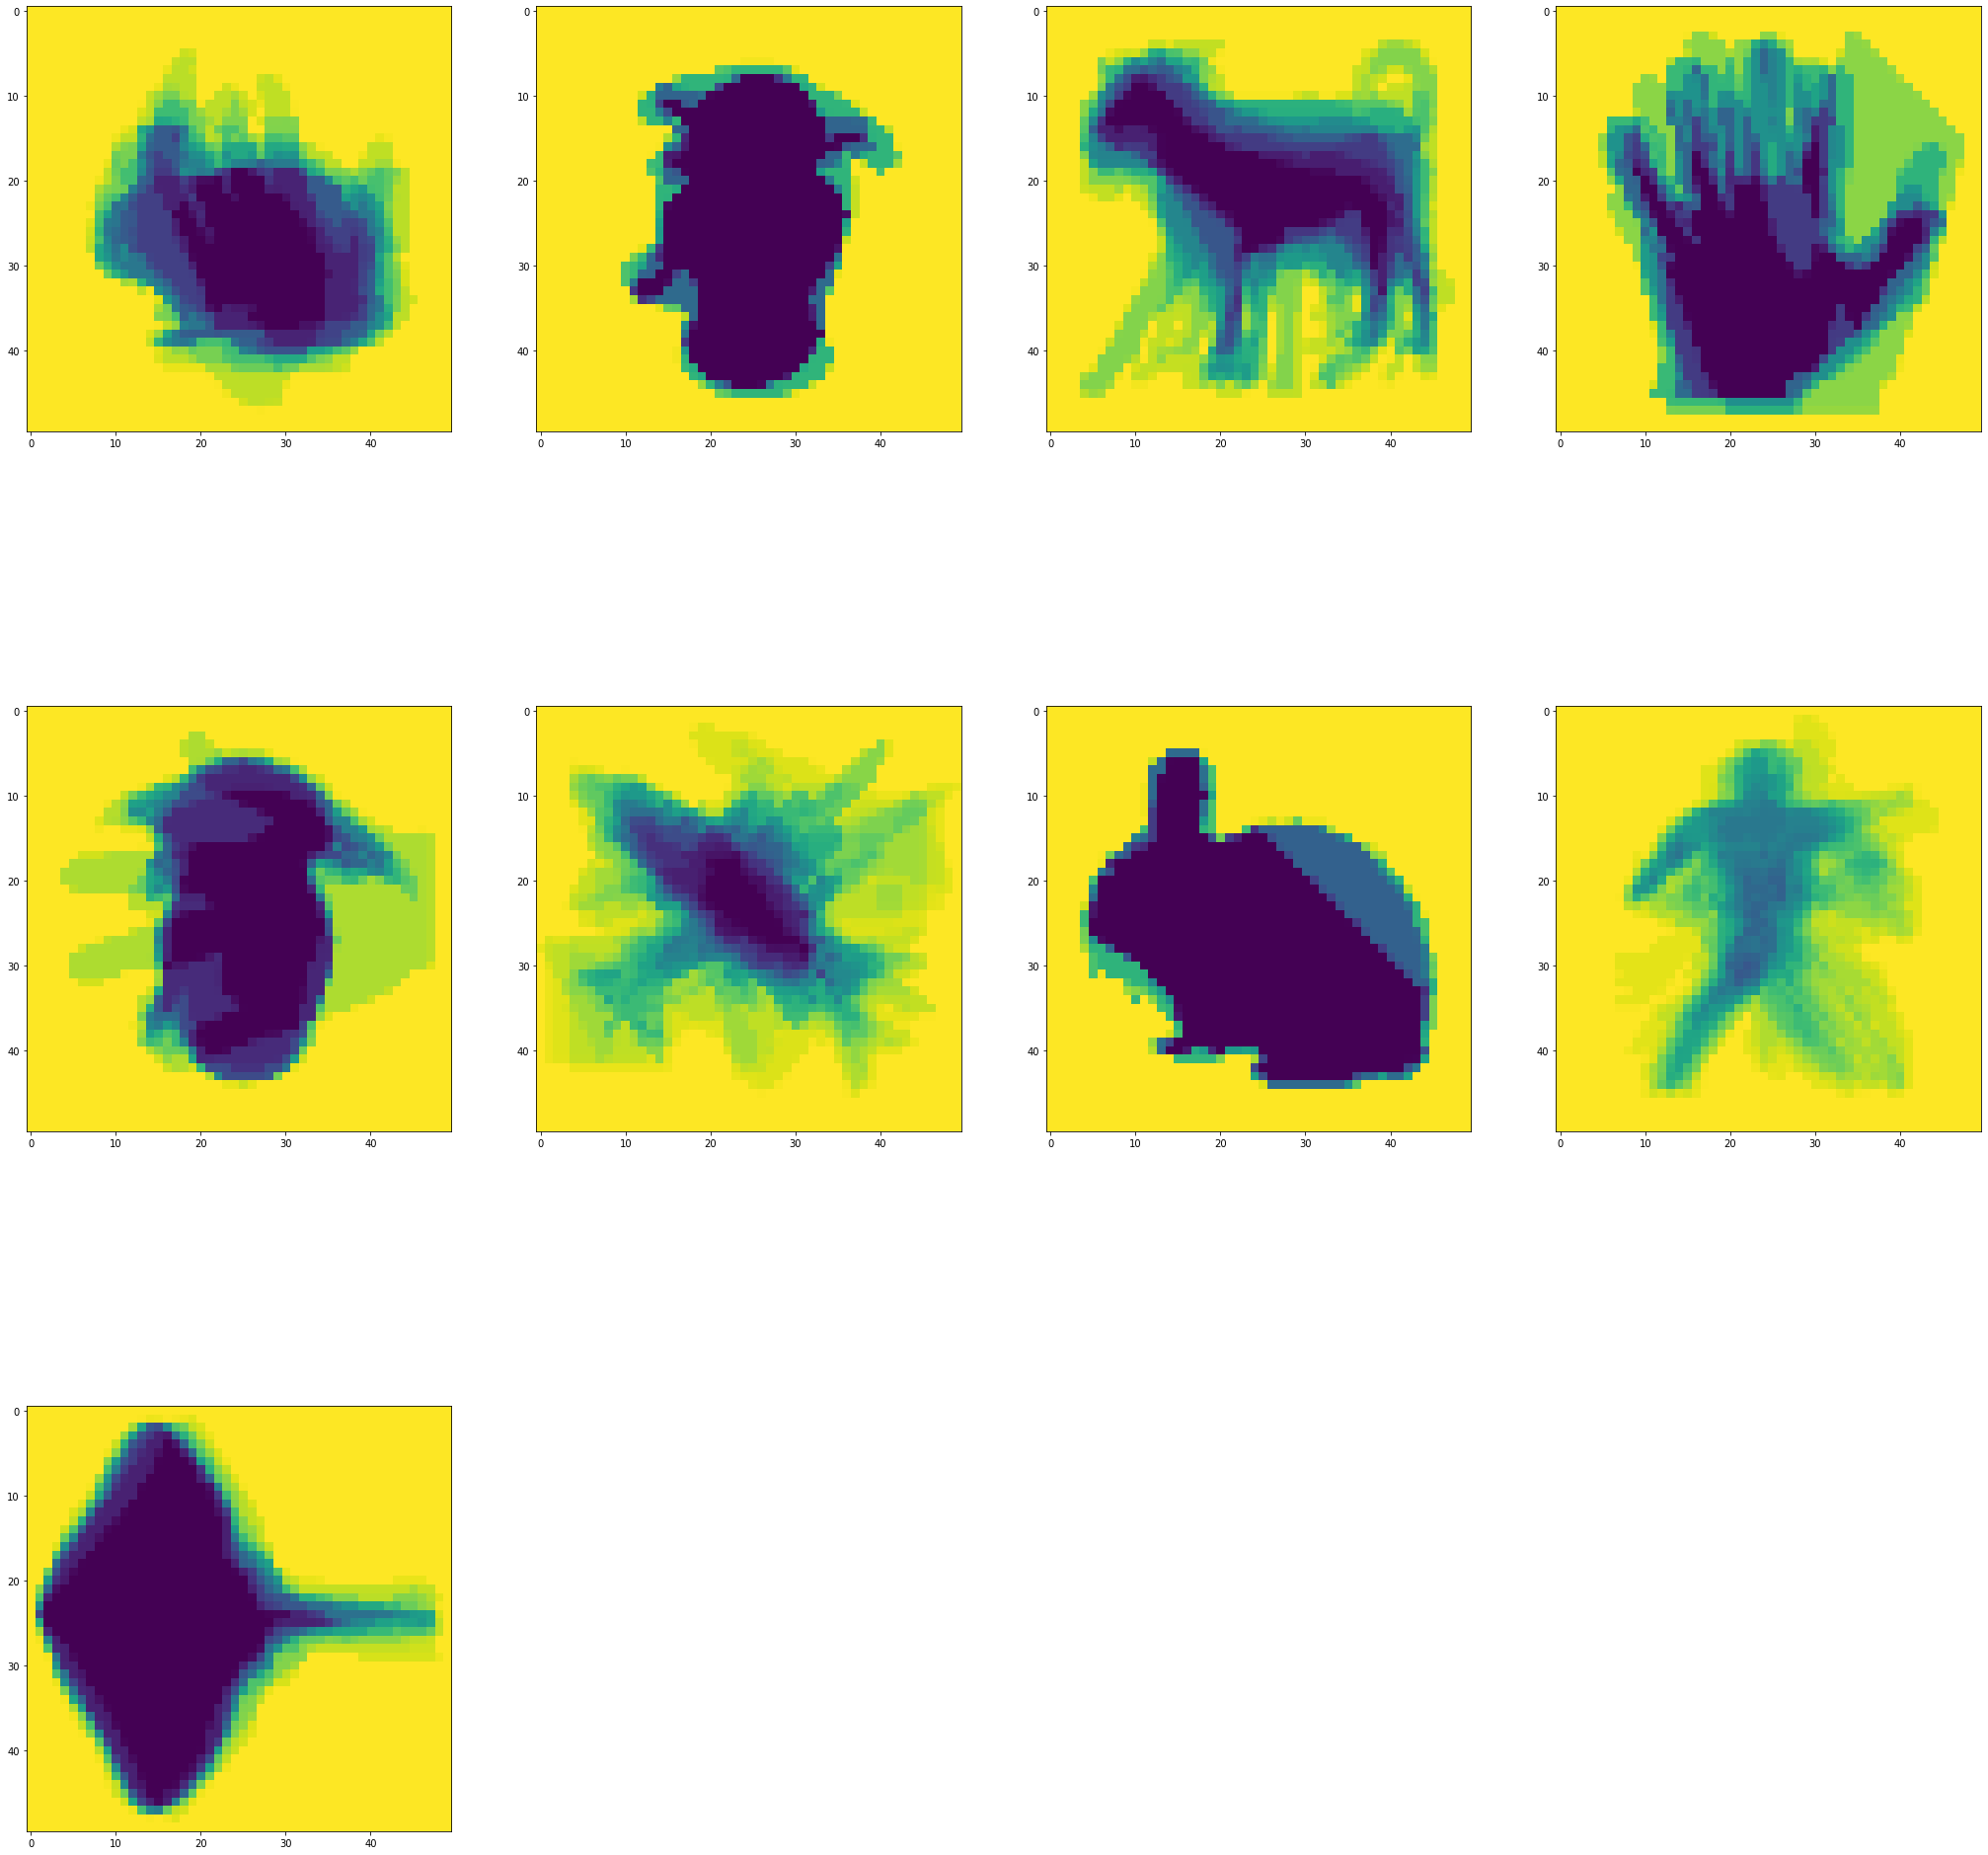

In [83]:
# visialize W3 (centroids)
# Reshaping input data back
W3 = W3.reshape(k,dim,dim)
plt.figure(figsize = (dim,dim))
bottom = 0.35
for i in range(k):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(W3[i],vmax=np.max(W3[i]),vmin = 0)

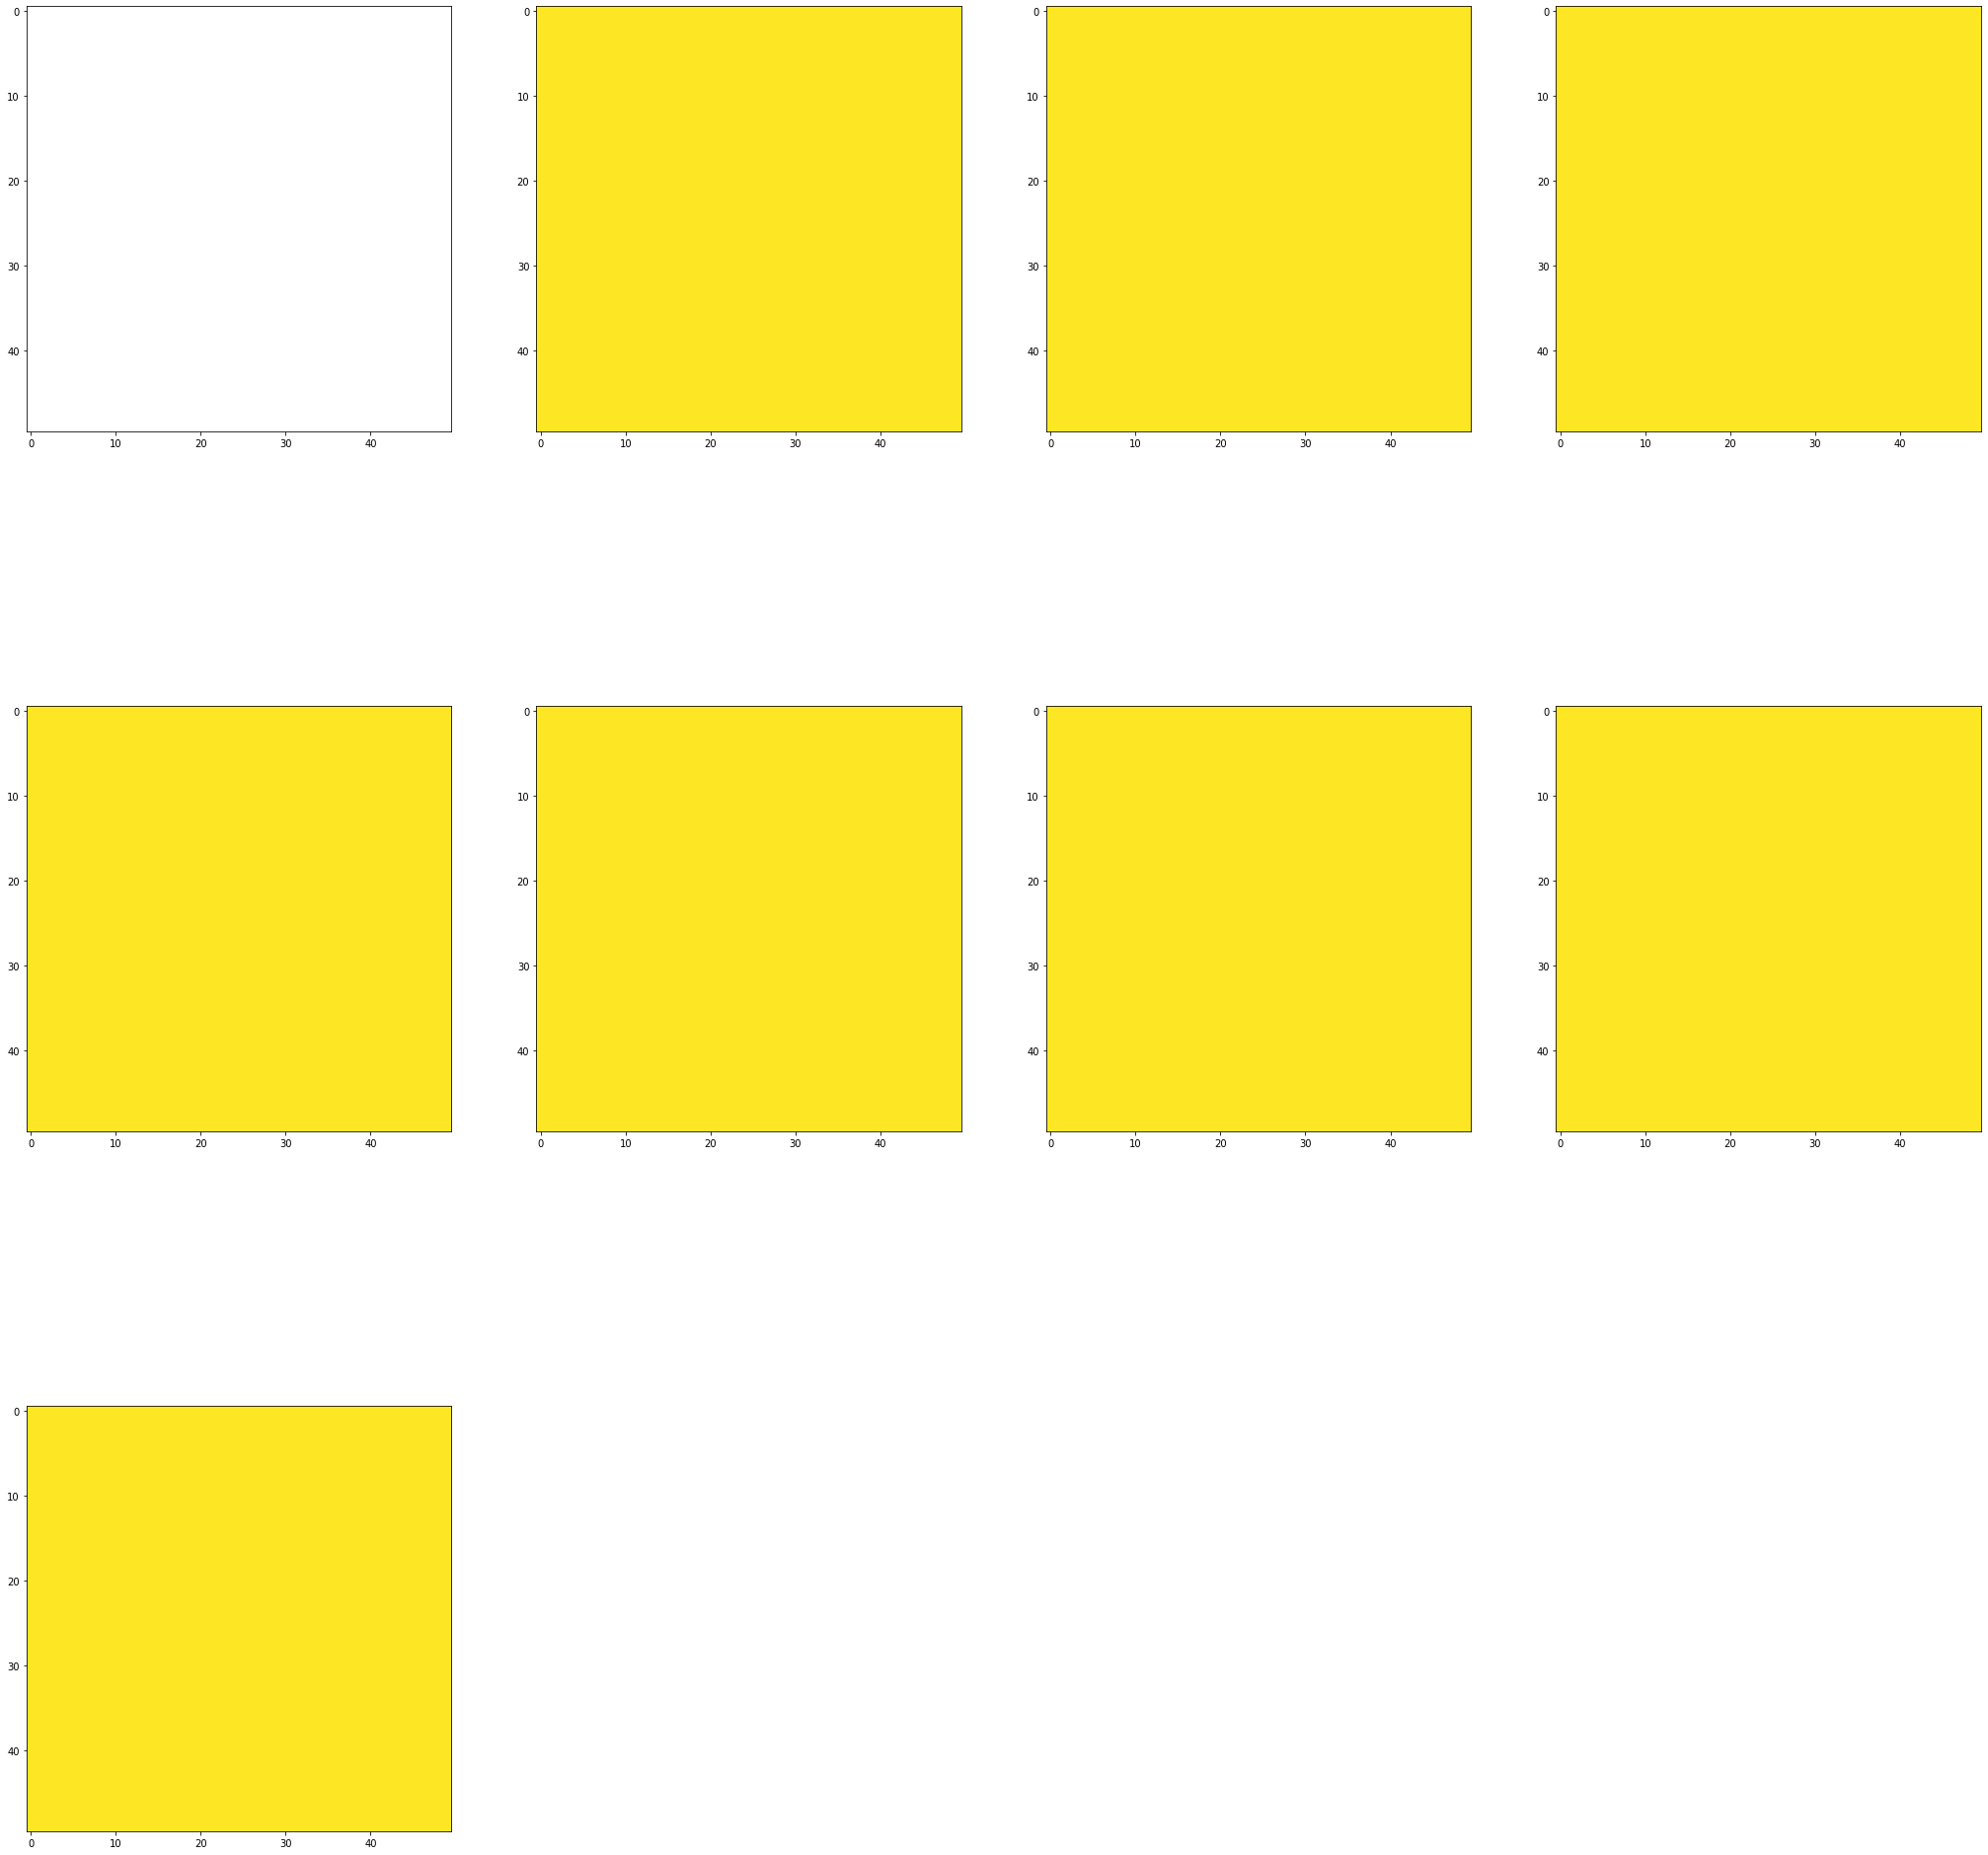

In [80]:
# visialize W4 (centroids)
# Reshaping input data back
W4 = W4.reshape(k,dim,dim)
plt.figure(figsize = (dim,dim))
bottom = 0.35
for i in range(k):
    plt.subplots_adjust(bottom)
    plt.subplot(4,4,i+1)
    plt.imshow(W4[i],vmax=np.max(W4[i]),vmin = 0)

In [56]:
from sklearn import cluster, datasets
circles = []
for i in range(20):
    noisy_circles = datasets.make_circles(n_samples=500, factor=.5,
                                      noise=0.1)
    circles.append(noisy_circles[0])

In [57]:
import numpy as np
mat = np.array(circles)
print(mat.shape)

(20, 500, 2)


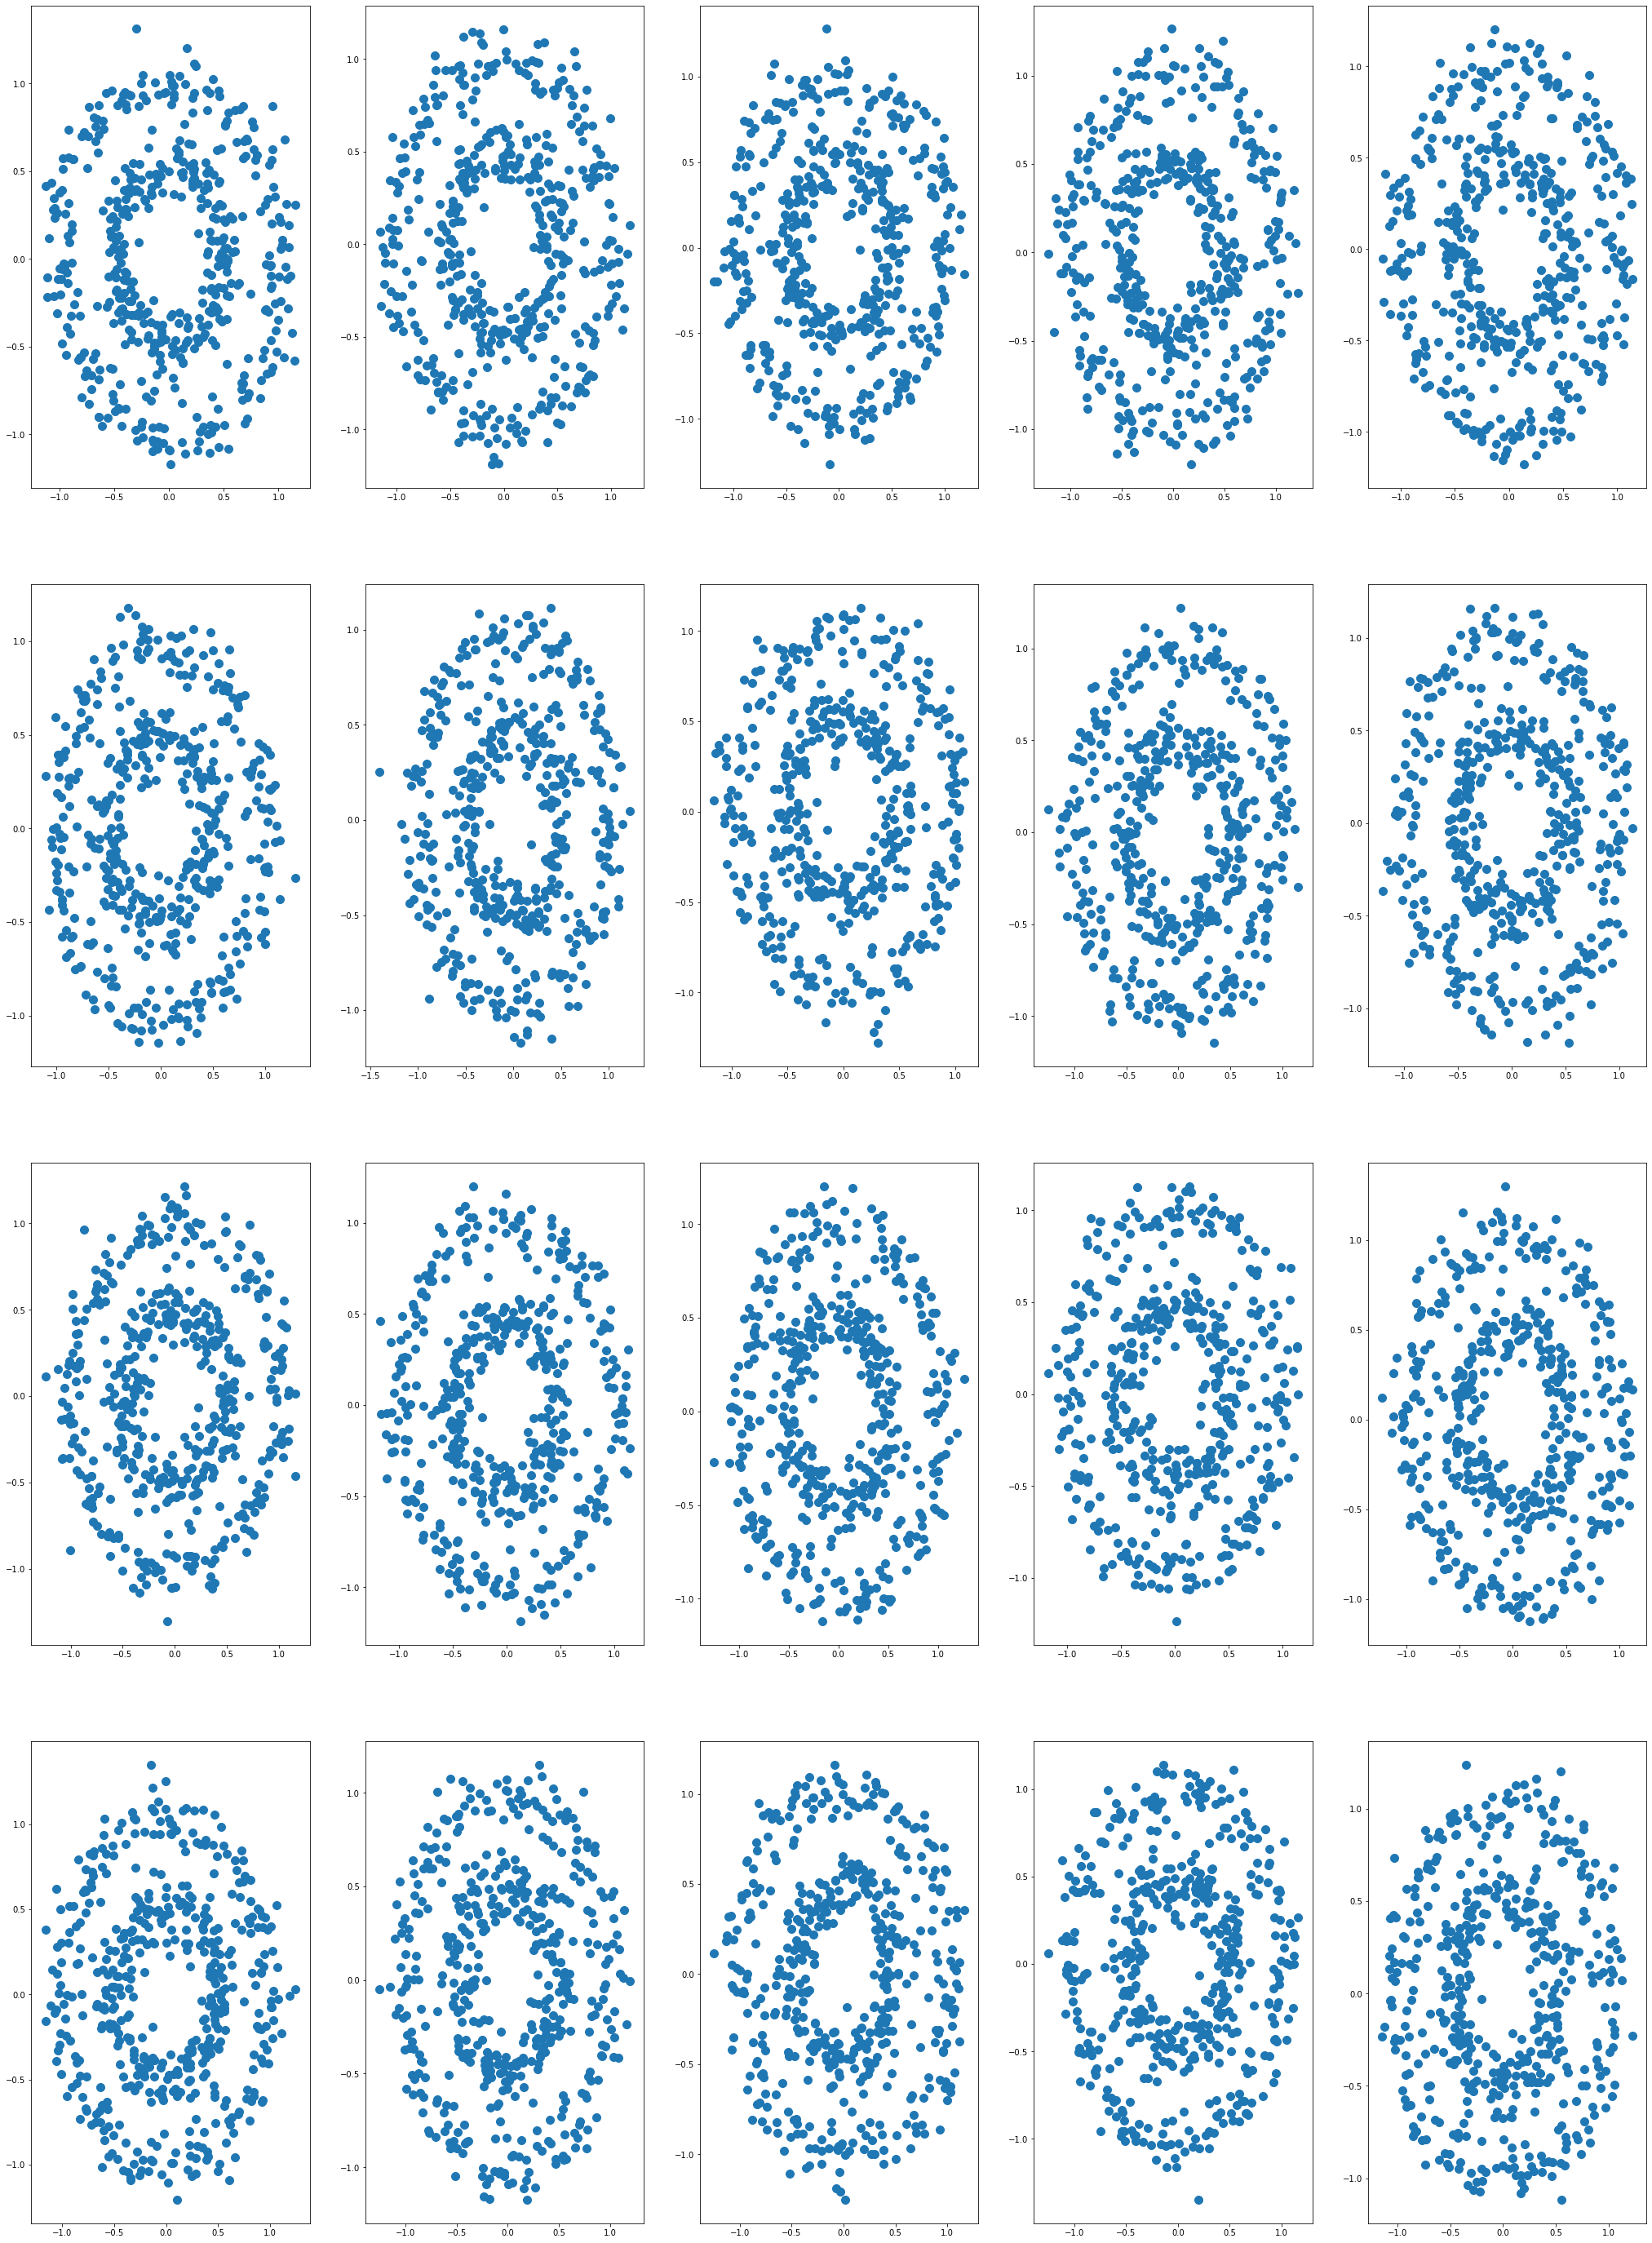

In [58]:
plt.figure(figsize = (50,50))
bottom = 0.35
for i in range(20):
    plt.subplots_adjust(bottom)
    plt.subplot(4,5,i+1)
    x = mat[i,:,0]
    y = mat[i,:,1]
    plt.scatter(x, y, s=100)
